# RTML 2025 | A3 | Transformers Assignment

## Final Report
-----------------
### Name: Arya Shah

### StudentID: st125462

This notebook consists of solutions for the following exercises:

(⚠️ Note that this is a Jupyter Notebook compiled from the individual python scripts and is not intended to be run as is)

1. Manage your available resources and continue fine-tune on the same dataset. The pretrained weights at 7th epoch (accuracy = 70%) is giving below link: (Hint: for batch_size = 8 on Puffer will used up 5GB of RAM in one GPU) ✅

https://drive.google.com/file/d/1Fewu2rhbqw99THDGPzDMPzgSu8J5iHfO/view?usp=sharing

2. Feel free to download the file and continue fine-tuning with different settings. Make a challenge to achieve a better performance than my result (at 30th, I got 94%). There is no bound for the number of epochs to continue. ✅

3. With your final fine-tuned weights, try to inference and get the result on images from "test" and "images to predict" directories in sport_dataset. Visualize some random inferenced images with their predictions. ✅

4. Describe your experience on fine-tuning and show the graphs. ✅

# 1. Managing Resources and Fine Tuning ✅

Since the dataset mentioned has changed its structure, I had to first download the new dataset on the puffer server using the following command:

```bash
curl -L https://www.kaggle.com/api/v1/datasets/download/gpiosenka/sports-classification | bsdtar -xf- -C ~/RTML/A3/sports-dataset/
```

Once the dataset was downloaded and unzipped, it was ready to use.

I downloaded the pretrained 7th Epoch Checkpoint and continued training first for 50 more epochs

# 2. Using Provided Weights And Fine Tuning ✅

I downloaded the `Ep.7.pth` weights provided on the drive and made use fo the same during training in the script below ✅

In [ ]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import random
from datetime import datetime
from tqdm import tqdm
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        
    def forward(self, x):
        return self.mha(x, x, x)[0]

class EncoderBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.ln_1 = nn.LayerNorm(hidden_dim)
        self.self_attention = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
        self.ln_2 = nn.LayerNorm(hidden_dim)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, hidden_dim),
        )
        
    def forward(self, x):
        x1 = self.ln_1(x)
        attention_output = self.self_attention(x1, x1, x1)[0]
        x2 = x + attention_output
        x3 = self.ln_2(x2)
        x3 = x2 + self.mlp(x3)
        return x3

class ViT(nn.Module):
    def __init__(self, 
                 input_shape=(3, 224, 224),
                 patch_size=16,
                 hidden_dim=768,
                 num_heads=12,
                 num_layers=12,
                 mlp_dim=3072,
                 num_classes=100,
                 dropout=0.1):
        super().__init__()
        
        # Image and patch sizes
        channels, image_h, image_w = input_shape
        assert image_h % patch_size == 0 and image_w % patch_size == 0, 'Image dimensions must be divisible by patch size'
        self.patch_size = patch_size
        num_patches = (image_h // patch_size) * (image_w // patch_size)
        patch_dim = channels * patch_size * patch_size
        
        # Linear projection of flattened patches
        self.patch_embed = nn.Linear(patch_dim, hidden_dim)
        
        # CLS token and position embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, hidden_dim))
        
        # Dropout
        self.pos_drop = nn.Dropout(p=dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            EncoderBlock(hidden_dim, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ])
        
        # Layer normalization
        self.norm = nn.LayerNorm(hidden_dim)
        
        # Classification head
        self.head = nn.Linear(hidden_dim, num_classes)
        
        # Initialize weights
        self.initialize_weights()
    
    def initialize_weights(self):
        # Initialize patch_embed like a linear layer
        nn.init.trunc_normal_(self.patch_embed.weight, std=0.02)
        nn.init.zeros_(self.patch_embed.bias)
        
        # Initialize cls_token
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        # Initialize position embedding
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
        # Initialize the rest of the layers
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias)
            nn.init.ones_(m.weight)
    
    def forward(self, x):
        # Get dimensions
        B, C, H, W = x.shape
        
        # Reshape and flatten the image into patches
        x = x.reshape(B, C, H // self.patch_size, self.patch_size, W // self.patch_size, self.patch_size)
        x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p, p]
        x = x.flatten(1, 2)  # [B, H'*W', C, p, p]
        x = x.flatten(2)  # [B, H'*W', C*p*p]
        
        # Linear embedding
        x = self.patch_embed(x)  # [B, H'*W', hidden_dim]
        
        # Add cls token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add position embedding
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Layer normalization
        x = self.norm(x)
        
        # Take cls token output
        x = x[:, 0]
        
        # Classification
        x = self.head(x)
        
        return x

class SportDataset(Dataset):
    """Sport dataset with directory structure: train/val/test with class subfolders."""
    
    def __init__(self, csv_file, root_dir, split='train', transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Root directory containing train/val/test folders.
            split (string): One of 'train', 'valid', or 'test'.
            transform (callable, optional): Optional transform to be applied on images.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Read the CSV file
        self.df = pd.read_csv(csv_file)
        
        # Filter by split
        self.df = self.df[self.df['data set'] == split]
        
        # Filter out non-image files
        valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
        self.df = self.df[self.df['filepaths'].apply(
            lambda x: os.path.splitext(x)[1].lower() in valid_extensions
        )]
        
        # Create class to index mapping
        self.classes = sorted(self.df['labels'].unique())
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}
        
        print(f"Loaded {split} split with {len(self.df)} images across {len(self.classes)} classes")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get the image path and label
        img_path = os.path.join(self.root_dir, self.df.iloc[idx]['filepaths'])
        label = self.class_to_idx[self.df.iloc[idx]['labels']]
        
        # Load and convert image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            # Return a different valid image
            valid_indices = [i for i in range(len(self)) if i != idx]
            if not valid_indices:  # If no other images available
                raise RuntimeError("No valid images found in the dataset")
            return self.__getitem__(random.choice(valid_indices))
        
        if self.transform:
            try:
                image = self.transform(image)
            except Exception as e:
                print(f"Error applying transform to {img_path}: {str(e)}")
                # Return a different valid image
                valid_indices = [i for i in range(len(self)) if i != idx]
                if not valid_indices:
                    raise RuntimeError("No valid images found in the dataset")
                return self.__getitem__(random.choice(valid_indices))
        
        return image, label

    def get_class_name(self, idx):
        """Get class name from class index."""
        return self.idx_to_class[idx]

In [ ]:
class FineTuner:
    def __init__(self, model, device, checkpoint_path=None):
        self.device = device
        self.model = model.to(device)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.writer = SummaryWriter(f'runs/finetune_{timestamp}')
        
        if checkpoint_path:
            print(f"Loading checkpoint from {checkpoint_path}")
            try:
                checkpoint = torch.load(checkpoint_path, map_location=device)
                print("Checkpoint structure:", type(checkpoint))
                if isinstance(checkpoint, dict):
                    print("Available keys in checkpoint:", checkpoint.keys())
                
                # Try different state dict keys that might be present
                if isinstance(checkpoint, dict):
                    if 'model_state_dict' in checkpoint:
                        state_dict = checkpoint['model_state_dict']
                    elif 'state_dict' in checkpoint:
                        state_dict = checkpoint['state_dict']
                    else:
                        state_dict = checkpoint  # Assume it's the state dict itself
                else:
                    state_dict = checkpoint  # Assume it's the state dict itself
                
                print("\nModel's state dict keys:", self.model.state_dict().keys())
                print("\nCheckpoint's state dict keys:", state_dict.keys())
                
                # Try to load the state dict directly first
                try:
                    missing_keys, unexpected_keys = self.model.load_state_dict(state_dict, strict=False)
                    if len(missing_keys) == 0 and len(unexpected_keys) == 0:
                        print("Checkpoint loaded successfully with direct mapping!")
                        return
                    else:
                        print("\nDirect loading had issues:")
                        print("Missing keys:", missing_keys)
                        print("Unexpected keys:", unexpected_keys)
                except Exception as e:
                    print("\nDirect loading failed:", str(e))
                
                # If direct loading fails, try remapping the keys
                print("\nAttempting to remap keys...")
                new_state_dict = {}
                for k, v in state_dict.items():
                    # Handle different key names
                    if k == 'pos_embed':
                        new_state_dict['pos_embedding'] = v
                    elif k == 'cls_token':
                        new_state_dict['class_token'] = v
                    elif k == 'patch_embed.proj':
                        new_state_dict['conv_proj'] = v
                    elif 'blocks.' in k:
                        # Convert blocks.0.xxx to encoder.layers.encoder_layer_0.xxx
                        parts = k.split('.')
                        if len(parts) >= 2:
                            layer_num = parts[1]
                            rest_key = '.'.join(parts[2:])
                            new_key = f'encoder.layers.encoder_layer_{layer_num}.{rest_key}'
                            new_state_dict[new_key] = v
                    elif k == 'norm':
                        new_state_dict['encoder.ln'] = v
                    elif k == 'head':
                        new_state_dict['heads.0'] = v
                    else:
                        new_state_dict[k] = v
                
                # Try loading the remapped state dict
                try:
                    missing_keys, unexpected_keys = self.model.load_state_dict(new_state_dict, strict=False)
                    print("\nAfter remapping:")
                    print("Missing keys:", missing_keys)
                    print("Unexpected keys:", unexpected_keys)
                    if len(missing_keys) == 0:
                        print("Checkpoint loaded successfully after remapping!")
                    else:
                        print("Warning: Some keys are still missing after remapping")
                except Exception as e:
                    print(f"Error loading remapped checkpoint: {str(e)}")
                    print("Starting with randomly initialized weights")
                    
            except Exception as e:
                print(f"Failed to load checkpoint: {str(e)}")
                print("Starting with randomly initialized weights")
    
    def train(self, train_loader, val_loader, epochs, lr=1e-4, weight_decay=1e-4):
        criterion = CrossEntropyLoss()
        optimizer = Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
        
        best_val_acc = 0.0
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []
        
        for epoch in range(epochs):
            # Training
            self.model.train()
            train_loss = 0.0
            correct = 0
            total = 0
            
            pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
            for batch_idx, (images, labels) in enumerate(pbar):
                images, labels = images.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)  # Add gradient clipping
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                # Update progress bar
                current_lr = optimizer.param_groups[0]['lr']
                pbar.set_postfix({
                    'loss': train_loss/(batch_idx+1), 
                    'acc': 100.*correct/total,
                    'lr': current_lr
                })
            
            train_loss = train_loss/len(train_loader)
            train_acc = 100.*correct/total
            
            # Validation
            val_loss, val_acc = self.evaluate(val_loader, criterion)
            
            # Learning rate scheduling
            scheduler.step()
            
            # Logging
            self.writer.add_scalar('Loss/train', train_loss, epoch)
            self.writer.add_scalar('Loss/val', val_loss, epoch)
            self.writer.add_scalar('Accuracy/train', train_acc, epoch)
            self.writer.add_scalar('Accuracy/val', val_acc, epoch)
            self.writer.add_scalar('Learning_rate', scheduler.get_last_lr()[0], epoch)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            
            print(f'\nEpoch {epoch+1}/{epochs}:')
            print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                self.save_checkpoint(epoch, optimizer, val_acc, 'best_model.pth')
                print(f'Saved new best model with validation accuracy: {val_acc:.2f}%')
            
            # Early stopping check (optional)
            if val_acc > 95.0:  # You can adjust this threshold
                print(f'\nReached {val_acc:.2f}% validation accuracy. Stopping training.')
                break
        
        return train_losses, val_losses, train_accs, val_accs
    
    def evaluate(self, loader, criterion):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        return val_loss/len(loader), 100.*correct/total
    
    def save_checkpoint(self, epoch, optimizer, val_acc, filename):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }
        torch.save(checkpoint, filename)
    
    def predict(self, image_tensor):
        self.model.eval()
        with torch.no_grad():
            image_tensor = image_tensor.unsqueeze(0).to(self.device)
            output = self.model(image_tensor)
            _, predicted = output.max(1)
            return predicted.item()
    
    def visualize_predictions(self, test_loader, class_names, num_images=8):
        images, labels = next(iter(test_loader))
        images = images[:num_images].to(self.device)
        labels = labels[:num_images]
        
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(images)
            _, predictions = outputs.max(1)
        
        # Plot images with predictions
        fig = plt.figure(figsize=(15, 8))
        for idx in range(num_images):
            ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
            img = images[idx].cpu().numpy().transpose((1, 2, 0))
            # Denormalize image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            ax.imshow(img)
            
            pred_idx = predictions[idx].cpu().item()
            true_idx = labels[idx].item()
            
            pred_label = class_names[pred_idx] if pred_idx in class_names else f"Unknown ({pred_idx})"
            true_label = class_names[true_idx] if true_idx in class_names else f"Unknown ({true_idx})"
            
            color = 'green' if pred_idx == true_idx else 'red'
            ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)
        
        plt.tight_layout()
        return fig

In [ ]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs, save_dir='.'):
    """Create detailed training history plots."""
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot losses
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss Over Time', fontsize=14, pad=10)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy Over Time', fontsize=14, pad=10)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend(fontsize=12)
    ax2.grid(True)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_history.png'), dpi=300, bbox_inches='tight')
    plt.close()

def evaluate_on_test_set(model, test_loader, device, class_names, save_dir='.'):
    """Evaluate model on test set and generate detailed report."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating on test set'):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Calculate accuracy
    accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    
    # Generate report
    report = f"Test Set Evaluation Report\n"
    report += f"{'='*50}\n"
    report += f"Overall Accuracy: {accuracy:.2f}%\n\n"
    
    # Per-class accuracy
    class_correct = {i: 0 for i in range(len(class_names))}
    class_total = {i: 0 for i in range(len(class_names))}
    
    for pred, label in zip(all_preds, all_labels):
        class_total[label] += 1
        if pred == label:
            class_correct[label] += 1
    
    report += "Per-Class Performance:\n"
    report += f"{'-'*50}\n"
    report += f"{'Class':<30} {'Accuracy':<10} {'Samples':<10}\n"
    report += f"{'-'*50}\n"
    
    for class_idx in range(len(class_names)):
        if class_total[class_idx] > 0:
            class_acc = 100 * class_correct[class_idx] / class_total[class_idx]
            report += f"{class_names[class_idx]:<30} {class_acc:>8.2f}% {class_total[class_idx]:>10}\n"
    
    # Save report
    with open(os.path.join(save_dir, 'test_report.txt'), 'w') as f:
        f.write(report)
    
    return accuracy, report

In [ ]:
if __name__ == '__main__':
    # Set random seed for reproducibility
    set_seed(42)
    
    # Create output directory for results
    output_dir = f'results_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Data augmentation and normalization
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    eval_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load datasets
    train_dataset = SportDataset(
        csv_file='sports-dataset/sports.csv',
        root_dir='sports-dataset',
        split='train',
        transform=train_transform
    )
    
    val_dataset = SportDataset(
        csv_file='sports-dataset/sports.csv',
        root_dir='sports-dataset',
        split='valid',
        transform=eval_transform
    )
    
    test_dataset = SportDataset(
        csv_file='sports-dataset/sports.csv',
        root_dir='sports-dataset',
        split='test',
        transform=eval_transform
    )
    
    if len(val_dataset) == 0:
        print("Warning: Validation dataset is empty! Please check the data split names in your CSV.")
        exit(1)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
    
    # Initialize model
    model = ViT(
        input_shape=(3, 224, 224),
        patch_size=16,
        hidden_dim=768,
        num_heads=12,
        num_layers=12,
        mlp_dim=3072,
        num_classes=len(train_dataset.classes)
    )
    
    # Print model summary
    print("\nModel Configuration:")
    print(f"Number of classes: {len(train_dataset.classes)}")
    print(f"Input shape: (3, 224, 224)")
    print(f"Patch size: 16")
    print(f"Hidden dimension: 768")
    print(f"Number of heads: 12")
    print(f"Number of layers: 12")
    print(f"MLP dimension: 3072")
    
    # Initialize trainer with checkpoint
    trainer = FineTuner(model, device, checkpoint_path='Ep.7.pth')
    
    # Training parameters
    num_epochs = 50
    learning_rate = 1e-4
    weight_decay = 1e-4
    
    print("\nTraining Configuration:")
    print(f"Number of epochs: {num_epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Weight decay: {weight_decay}")
    print(f"Batch size: 8")
    
    # Train the model
    train_losses, val_losses, train_accs, val_accs = trainer.train(
        train_loader, 
        val_loader, 
        num_epochs, 
        learning_rate, 
        weight_decay
    )
    
    # Plot and save training history
    plot_training_history(train_losses, val_losses, train_accs, val_accs, output_dir)
    
    # Load best model for evaluation
    best_model_path = 'best_model.pth'
    if os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"\nLoaded best model from epoch {checkpoint['epoch']} "
              f"with validation accuracy: {checkpoint['val_acc']:.2f}%")
    
    # Evaluate on test set
    test_accuracy, test_report = evaluate_on_test_set(
        model, test_loader, device, 
        train_dataset.idx_to_class, output_dir
    )
    print("\nTest Set Evaluation:")
    print(test_report)
    
    # Visualize some predictions
    pred_fig = trainer.visualize_predictions(test_loader, train_dataset.idx_to_class, num_images=8)
    pred_fig.savefig(os.path.join(output_dir, 'test_predictions.png'))
    
    print(f"\nTraining completed! Results saved in '{output_dir}' directory.")
    print("Check the following files:")
    print(f"1. {output_dir}/training_history.png - Training progress plots")
    print(f"2. {output_dir}/test_report.txt - Detailed test set evaluation")
    print(f"3. {output_dir}/test_predictions.png - Sample predictions visualization")


jupyter-st125462@puffer:~/RTML/A3$ python finetune_vit_complete.py
Using device: cuda
Loaded train split with 13492 images across 100 classes
Loaded valid split with 500 images across 100 classes
Loaded test split with 500 images across 100 classes

Model Configuration:
Number of classes: 100
Input shape: (3, 224, 224)
Patch size: 16
Hidden dimension: 768
Number of heads: 12
Number of layers: 12
MLP dimension: 3072
Loading checkpoint from Ep.7.pth
/home/jupyter-st125462/RTML/A3/finetune_vit_complete.py:240: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
Checkpoint structure: <class 'collections.OrderedDict'>
Available keys in checkpoint: odict_keys(['class_token', 'conv_proj.weight', 'conv_proj.bias', 'encoder.pos_embedding', 'encoder.layers.encoder_layer_0.ln_1.weight', 'encoder.layers.encoder_layer_0.ln_1.bias', 'encoder.layers.encoder_layer_0.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_0.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_0.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_0.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_0.ln_2.weight', 'encoder.layers.encoder_layer_0.ln_2.bias', 'encoder.layers.encoder_layer_0.mlp.0.weight', 'encoder.layers.encoder_layer_0.mlp.0.bias', 'encoder.layers.encoder_layer_0.mlp.3.weight', 'encoder.layers.encoder_layer_0.mlp.3.bias', 'encoder.layers.encoder_layer_1.ln_1.weight', 'encoder.layers.encoder_layer_1.ln_1.bias', 'encoder.layers.encoder_layer_1.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_1.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_1.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_1.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_1.ln_2.weight', 'encoder.layers.encoder_layer_1.ln_2.bias', 'encoder.layers.encoder_layer_1.mlp.0.weight', 'encoder.layers.encoder_layer_1.mlp.0.bias', 'encoder.layers.encoder_layer_1.mlp.3.weight', 'encoder.layers.encoder_layer_1.mlp.3.bias', 'encoder.layers.encoder_layer_2.ln_1.weight', 'encoder.layers.encoder_layer_2.ln_1.bias', 'encoder.layers.encoder_layer_2.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_2.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_2.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_2.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_2.ln_2.weight', 'encoder.layers.encoder_layer_2.ln_2.bias', 'encoder.layers.encoder_layer_2.mlp.0.weight', 'encoder.layers.encoder_layer_2.mlp.0.bias', 'encoder.layers.encoder_layer_2.mlp.3.weight', 'encoder.layers.encoder_layer_2.mlp.3.bias', 'encoder.layers.encoder_layer_3.ln_1.weight', 'encoder.layers.encoder_layer_3.ln_1.bias', 'encoder.layers.encoder_layer_3.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_3.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_3.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_3.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_3.ln_2.weight', 'encoder.layers.encoder_layer_3.ln_2.bias', 'encoder.layers.encoder_layer_3.mlp.0.weight', 'encoder.layers.encoder_layer_3.mlp.0.bias', 'encoder.layers.encoder_layer_3.mlp.3.weight', 'encoder.layers.encoder_layer_3.mlp.3.bias', 'encoder.layers.encoder_layer_4.ln_1.weight', 'encoder.layers.encoder_layer_4.ln_1.bias', 'encoder.layers.encoder_layer_4.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_4.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_4.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_4.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_4.ln_2.weight', 'encoder.layers.encoder_layer_4.ln_2.bias', 'encoder.layers.encoder_layer_4.mlp.0.weight', 'encoder.layers.encoder_layer_4.mlp.0.bias', 'encoder.layers.encoder_layer_4.mlp.3.weight', 'encoder.layers.encoder_layer_4.mlp.3.bias', 'encoder.layers.encoder_layer_5.ln_1.weight', 'encoder.layers.encoder_layer_5.ln_1.bias', 'encoder.layers.encoder_layer_5.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_5.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_5.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_5.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_5.ln_2.weight', 'encoder.layers.encoder_layer_5.ln_2.bias', 'encoder.layers.encoder_layer_5.mlp.0.weight', 'encoder.layers.encoder_layer_5.mlp.0.bias', 'encoder.layers.encoder_layer_5.mlp.3.weight', 'encoder.layers.encoder_layer_5.mlp.3.bias', 'encoder.layers.encoder_layer_6.ln_1.weight', 'encoder.layers.encoder_layer_6.ln_1.bias', 'encoder.layers.encoder_layer_6.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_6.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_6.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_6.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_6.ln_2.weight', 'encoder.layers.encoder_layer_6.ln_2.bias', 'encoder.layers.encoder_layer_6.mlp.0.weight', 'encoder.layers.encoder_layer_6.mlp.0.bias', 'encoder.layers.encoder_layer_6.mlp.3.weight', 'encoder.layers.encoder_layer_6.mlp.3.bias', 'encoder.layers.encoder_layer_7.ln_1.weight', 'encoder.layers.encoder_layer_7.ln_1.bias', 'encoder.layers.encoder_layer_7.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_7.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_7.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_7.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_7.ln_2.weight', 'encoder.layers.encoder_layer_7.ln_2.bias', 'encoder.layers.encoder_layer_7.mlp.0.weight', 'encoder.layers.encoder_layer_7.mlp.0.bias', 'encoder.layers.encoder_layer_7.mlp.3.weight', 'encoder.layers.encoder_layer_7.mlp.3.bias', 'encoder.layers.encoder_layer_8.ln_1.weight', 'encoder.layers.encoder_layer_8.ln_1.bias', 'encoder.layers.encoder_layer_8.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_8.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_8.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_8.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_8.ln_2.weight', 'encoder.layers.encoder_layer_8.ln_2.bias', 'encoder.layers.encoder_layer_8.mlp.0.weight', 'encoder.layers.encoder_layer_8.mlp.0.bias', 'encoder.layers.encoder_layer_8.mlp.3.weight', 'encoder.layers.encoder_layer_8.mlp.3.bias', 'encoder.layers.encoder_layer_9.ln_1.weight', 'encoder.layers.encoder_layer_9.ln_1.bias', 'encoder.layers.encoder_layer_9.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_9.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_9.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_9.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_9.ln_2.weight', 'encoder.layers.encoder_layer_9.ln_2.bias', 'encoder.layers.encoder_layer_9.mlp.0.weight', 'encoder.layers.encoder_layer_9.mlp.0.bias', 'encoder.layers.encoder_layer_9.mlp.3.weight', 'encoder.layers.encoder_layer_9.mlp.3.bias', 'encoder.layers.encoder_layer_10.ln_1.weight', 'encoder.layers.encoder_layer_10.ln_1.bias', 'encoder.layers.encoder_layer_10.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_10.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_10.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_10.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_10.ln_2.weight', 'encoder.layers.encoder_layer_10.ln_2.bias', 'encoder.layers.encoder_layer_10.mlp.0.weight', 'encoder.layers.encoder_layer_10.mlp.0.bias', 'encoder.layers.encoder_layer_10.mlp.3.weight', 'encoder.layers.encoder_layer_10.mlp.3.bias', 'encoder.layers.encoder_layer_11.ln_1.weight', 'encoder.layers.encoder_layer_11.ln_1.bias', 'encoder.layers.encoder_layer_11.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_11.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_11.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_11.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_11.ln_2.weight', 'encoder.layers.encoder_layer_11.ln_2.bias', 'encoder.layers.encoder_layer_11.mlp.0.weight', 'encoder.layers.encoder_layer_11.mlp.0.bias', 'encoder.layers.encoder_layer_11.mlp.3.weight', 'encoder.layers.encoder_layer_11.mlp.3.bias', 'encoder.ln.weight', 'encoder.ln.bias', 'heads.0.weight', 'heads.0.bias'])

Model's state dict keys: odict_keys(['cls_token', 'pos_embed', 'patch_embed.weight', 'patch_embed.bias', 'blocks.0.ln_1.weight', 'blocks.0.ln_1.bias', 'blocks.0.self_attention.in_proj_weight', 'blocks.0.self_attention.in_proj_bias', 'blocks.0.self_attention.out_proj.weight', 'blocks.0.self_attention.out_proj.bias', 'blocks.0.ln_2.weight', 'blocks.0.ln_2.bias', 'blocks.0.mlp.0.weight', 'blocks.0.mlp.0.bias', 'blocks.0.mlp.3.weight', 'blocks.0.mlp.3.bias', 'blocks.1.ln_1.weight', 'blocks.1.ln_1.bias', 'blocks.1.self_attention.in_proj_weight', 'blocks.1.self_attention.in_proj_bias', 'blocks.1.self_attention.out_proj.weight', 'blocks.1.self_attention.out_proj.bias', 'blocks.1.ln_2.weight', 'blocks.1.ln_2.bias', 'blocks.1.mlp.0.weight', 'blocks.1.mlp.0.bias', 'blocks.1.mlp.3.weight', 'blocks.1.mlp.3.bias', 'blocks.2.ln_1.weight', 'blocks.2.ln_1.bias', 'blocks.2.self_attention.in_proj_weight', 'blocks.2.self_attention.in_proj_bias', 'blocks.2.self_attention.out_proj.weight', 'blocks.2.self_attention.out_proj.bias', 'blocks.2.ln_2.weight', 'blocks.2.ln_2.bias', 'blocks.2.mlp.0.weight', 'blocks.2.mlp.0.bias', 'blocks.2.mlp.3.weight', 'blocks.2.mlp.3.bias', 'blocks.3.ln_1.weight', 'blocks.3.ln_1.bias', 'blocks.3.self_attention.in_proj_weight', 'blocks.3.self_attention.in_proj_bias', 'blocks.3.self_attention.out_proj.weight', 'blocks.3.self_attention.out_proj.bias', 'blocks.3.ln_2.weight', 'blocks.3.ln_2.bias', 'blocks.3.mlp.0.weight', 'blocks.3.mlp.0.bias', 'blocks.3.mlp.3.weight', 'blocks.3.mlp.3.bias', 'blocks.4.ln_1.weight', 'blocks.4.ln_1.bias', 'blocks.4.self_attention.in_proj_weight', 'blocks.4.self_attention.in_proj_bias', 'blocks.4.self_attention.out_proj.weight', 'blocks.4.self_attention.out_proj.bias', 'blocks.4.ln_2.weight', 'blocks.4.ln_2.bias', 'blocks.4.mlp.0.weight', 'blocks.4.mlp.0.bias', 'blocks.4.mlp.3.weight', 'blocks.4.mlp.3.bias', 'blocks.5.ln_1.weight', 'blocks.5.ln_1.bias', 'blocks.5.self_attention.in_proj_weight', 'blocks.5.self_attention.in_proj_bias', 'blocks.5.self_attention.out_proj.weight', 'blocks.5.self_attention.out_proj.bias', 'blocks.5.ln_2.weight', 'blocks.5.ln_2.bias', 'blocks.5.mlp.0.weight', 'blocks.5.mlp.0.bias', 'blocks.5.mlp.3.weight', 'blocks.5.mlp.3.bias', 'blocks.6.ln_1.weight', 'blocks.6.ln_1.bias', 'blocks.6.self_attention.in_proj_weight', 'blocks.6.self_attention.in_proj_bias', 'blocks.6.self_attention.out_proj.weight', 'blocks.6.self_attention.out_proj.bias', 'blocks.6.ln_2.weight', 'blocks.6.ln_2.bias', 'blocks.6.mlp.0.weight', 'blocks.6.mlp.0.bias', 'blocks.6.mlp.3.weight', 'blocks.6.mlp.3.bias', 'blocks.7.ln_1.weight', 'blocks.7.ln_1.bias', 'blocks.7.self_attention.in_proj_weight', 'blocks.7.self_attention.in_proj_bias', 'blocks.7.self_attention.out_proj.weight', 'blocks.7.self_attention.out_proj.bias', 'blocks.7.ln_2.weight', 'blocks.7.ln_2.bias', 'blocks.7.mlp.0.weight', 'blocks.7.mlp.0.bias', 'blocks.7.mlp.3.weight', 'blocks.7.mlp.3.bias', 'blocks.8.ln_1.weight', 'blocks.8.ln_1.bias', 'blocks.8.self_attention.in_proj_weight', 'blocks.8.self_attention.in_proj_bias', 'blocks.8.self_attention.out_proj.weight', 'blocks.8.self_attention.out_proj.bias', 'blocks.8.ln_2.weight', 'blocks.8.ln_2.bias', 'blocks.8.mlp.0.weight', 'blocks.8.mlp.0.bias', 'blocks.8.mlp.3.weight', 'blocks.8.mlp.3.bias', 'blocks.9.ln_1.weight', 'blocks.9.ln_1.bias', 'blocks.9.self_attention.in_proj_weight', 'blocks.9.self_attention.in_proj_bias', 'blocks.9.self_attention.out_proj.weight', 'blocks.9.self_attention.out_proj.bias', 'blocks.9.ln_2.weight', 'blocks.9.ln_2.bias', 'blocks.9.mlp.0.weight', 'blocks.9.mlp.0.bias', 'blocks.9.mlp.3.weight', 'blocks.9.mlp.3.bias', 'blocks.10.ln_1.weight', 'blocks.10.ln_1.bias', 'blocks.10.self_attention.in_proj_weight', 'blocks.10.self_attention.in_proj_bias', 'blocks.10.self_attention.out_proj.weight', 'blocks.10.self_attention.out_proj.bias', 'blocks.10.ln_2.weight', 'blocks.10.ln_2.bias', 'blocks.10.mlp.0.weight', 'blocks.10.mlp.0.bias', 'blocks.10.mlp.3.weight', 'blocks.10.mlp.3.bias', 'blocks.11.ln_1.weight', 'blocks.11.ln_1.bias', 'blocks.11.self_attention.in_proj_weight', 'blocks.11.self_attention.in_proj_bias', 'blocks.11.self_attention.out_proj.weight', 'blocks.11.self_attention.out_proj.bias', 'blocks.11.ln_2.weight', 'blocks.11.ln_2.bias', 'blocks.11.mlp.0.weight', 'blocks.11.mlp.0.bias', 'blocks.11.mlp.3.weight', 'blocks.11.mlp.3.bias', 'norm.weight', 'norm.bias', 'head.weight', 'head.bias'])

Checkpoint's state dict keys: odict_keys(['class_token', 'conv_proj.weight', 'conv_proj.bias', 'encoder.pos_embedding', 'encoder.layers.encoder_layer_0.ln_1.weight', 'encoder.layers.encoder_layer_0.ln_1.bias', 'encoder.layers.encoder_layer_0.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_0.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_0.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_0.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_0.ln_2.weight', 'encoder.layers.encoder_layer_0.ln_2.bias', 'encoder.layers.encoder_layer_0.mlp.0.weight', 'encoder.layers.encoder_layer_0.mlp.0.bias', 'encoder.layers.encoder_layer_0.mlp.3.weight', 'encoder.layers.encoder_layer_0.mlp.3.bias', 'encoder.layers.encoder_layer_1.ln_1.weight', 'encoder.layers.encoder_layer_1.ln_1.bias', 'encoder.layers.encoder_layer_1.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_1.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_1.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_1.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_1.ln_2.weight', 'encoder.layers.encoder_layer_1.ln_2.bias', 'encoder.layers.encoder_layer_1.mlp.0.weight', 'encoder.layers.encoder_layer_1.mlp.0.bias', 'encoder.layers.encoder_layer_1.mlp.3.weight', 'encoder.layers.encoder_layer_1.mlp.3.bias', 'encoder.layers.encoder_layer_2.ln_1.weight', 'encoder.layers.encoder_layer_2.ln_1.bias', 'encoder.layers.encoder_layer_2.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_2.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_2.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_2.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_2.ln_2.weight', 'encoder.layers.encoder_layer_2.ln_2.bias', 'encoder.layers.encoder_layer_2.mlp.0.weight', 'encoder.layers.encoder_layer_2.mlp.0.bias', 'encoder.layers.encoder_layer_2.mlp.3.weight', 'encoder.layers.encoder_layer_2.mlp.3.bias', 'encoder.layers.encoder_layer_3.ln_1.weight', 'encoder.layers.encoder_layer_3.ln_1.bias', 'encoder.layers.encoder_layer_3.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_3.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_3.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_3.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_3.ln_2.weight', 'encoder.layers.encoder_layer_3.ln_2.bias', 'encoder.layers.encoder_layer_3.mlp.0.weight', 'encoder.layers.encoder_layer_3.mlp.0.bias', 'encoder.layers.encoder_layer_3.mlp.3.weight', 'encoder.layers.encoder_layer_3.mlp.3.bias', 'encoder.layers.encoder_layer_4.ln_1.weight', 'encoder.layers.encoder_layer_4.ln_1.bias', 'encoder.layers.encoder_layer_4.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_4.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_4.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_4.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_4.ln_2.weight', 'encoder.layers.encoder_layer_4.ln_2.bias', 'encoder.layers.encoder_layer_4.mlp.0.weight', 'encoder.layers.encoder_layer_4.mlp.0.bias', 'encoder.layers.encoder_layer_4.mlp.3.weight', 'encoder.layers.encoder_layer_4.mlp.3.bias', 'encoder.layers.encoder_layer_5.ln_1.weight', 'encoder.layers.encoder_layer_5.ln_1.bias', 'encoder.layers.encoder_layer_5.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_5.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_5.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_5.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_5.ln_2.weight', 'encoder.layers.encoder_layer_5.ln_2.bias', 'encoder.layers.encoder_layer_5.mlp.0.weight', 'encoder.layers.encoder_layer_5.mlp.0.bias', 'encoder.layers.encoder_layer_5.mlp.3.weight', 'encoder.layers.encoder_layer_5.mlp.3.bias', 'encoder.layers.encoder_layer_6.ln_1.weight', 'encoder.layers.encoder_layer_6.ln_1.bias', 'encoder.layers.encoder_layer_6.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_6.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_6.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_6.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_6.ln_2.weight', 'encoder.layers.encoder_layer_6.ln_2.bias', 'encoder.layers.encoder_layer_6.mlp.0.weight', 'encoder.layers.encoder_layer_6.mlp.0.bias', 'encoder.layers.encoder_layer_6.mlp.3.weight', 'encoder.layers.encoder_layer_6.mlp.3.bias', 'encoder.layers.encoder_layer_7.ln_1.weight', 'encoder.layers.encoder_layer_7.ln_1.bias', 'encoder.layers.encoder_layer_7.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_7.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_7.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_7.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_7.ln_2.weight', 'encoder.layers.encoder_layer_7.ln_2.bias', 'encoder.layers.encoder_layer_7.mlp.0.weight', 'encoder.layers.encoder_layer_7.mlp.0.bias', 'encoder.layers.encoder_layer_7.mlp.3.weight', 'encoder.layers.encoder_layer_7.mlp.3.bias', 'encoder.layers.encoder_layer_8.ln_1.weight', 'encoder.layers.encoder_layer_8.ln_1.bias', 'encoder.layers.encoder_layer_8.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_8.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_8.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_8.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_8.ln_2.weight', 'encoder.layers.encoder_layer_8.ln_2.bias', 'encoder.layers.encoder_layer_8.mlp.0.weight', 'encoder.layers.encoder_layer_8.mlp.0.bias', 'encoder.layers.encoder_layer_8.mlp.3.weight', 'encoder.layers.encoder_layer_8.mlp.3.bias', 'encoder.layers.encoder_layer_9.ln_1.weight', 'encoder.layers.encoder_layer_9.ln_1.bias', 'encoder.layers.encoder_layer_9.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_9.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_9.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_9.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_9.ln_2.weight', 'encoder.layers.encoder_layer_9.ln_2.bias', 'encoder.layers.encoder_layer_9.mlp.0.weight', 'encoder.layers.encoder_layer_9.mlp.0.bias', 'encoder.layers.encoder_layer_9.mlp.3.weight', 'encoder.layers.encoder_layer_9.mlp.3.bias', 'encoder.layers.encoder_layer_10.ln_1.weight', 'encoder.layers.encoder_layer_10.ln_1.bias', 'encoder.layers.encoder_layer_10.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_10.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_10.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_10.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_10.ln_2.weight', 'encoder.layers.encoder_layer_10.ln_2.bias', 'encoder.layers.encoder_layer_10.mlp.0.weight', 'encoder.layers.encoder_layer_10.mlp.0.bias', 'encoder.layers.encoder_layer_10.mlp.3.weight', 'encoder.layers.encoder_layer_10.mlp.3.bias', 'encoder.layers.encoder_layer_11.ln_1.weight', 'encoder.layers.encoder_layer_11.ln_1.bias', 'encoder.layers.encoder_layer_11.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_11.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_11.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_11.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_11.ln_2.weight', 'encoder.layers.encoder_layer_11.ln_2.bias', 'encoder.layers.encoder_layer_11.mlp.0.weight', 'encoder.layers.encoder_layer_11.mlp.0.bias', 'encoder.layers.encoder_layer_11.mlp.3.weight', 'encoder.layers.encoder_layer_11.mlp.3.bias', 'encoder.ln.weight', 'encoder.ln.bias', 'heads.0.weight', 'heads.0.bias'])

Direct loading had issues:
Missing keys: ['cls_token', 'pos_embed', 'patch_embed.weight', 'patch_embed.bias', 'blocks.0.ln_1.weight', 'blocks.0.ln_1.bias', 'blocks.0.self_attention.in_proj_weight', 'blocks.0.self_attention.in_proj_bias', 'blocks.0.self_attention.out_proj.weight', 'blocks.0.self_attention.out_proj.bias', 'blocks.0.ln_2.weight', 'blocks.0.ln_2.bias', 'blocks.0.mlp.0.weight', 'blocks.0.mlp.0.bias', 'blocks.0.mlp.3.weight', 'blocks.0.mlp.3.bias', 'blocks.1.ln_1.weight', 'blocks.1.ln_1.bias', 'blocks.1.self_attention.in_proj_weight', 'blocks.1.self_attention.in_proj_bias', 'blocks.1.self_attention.out_proj.weight', 'blocks.1.self_attention.out_proj.bias', 'blocks.1.ln_2.weight', 'blocks.1.ln_2.bias', 'blocks.1.mlp.0.weight', 'blocks.1.mlp.0.bias', 'blocks.1.mlp.3.weight', 'blocks.1.mlp.3.bias', 'blocks.2.ln_1.weight', 'blocks.2.ln_1.bias', 'blocks.2.self_attention.in_proj_weight', 'blocks.2.self_attention.in_proj_bias', 'blocks.2.self_attention.out_proj.weight', 'blocks.2.self_attention.out_proj.bias', 'blocks.2.ln_2.weight', 'blocks.2.ln_2.bias', 'blocks.2.mlp.0.weight', 'blocks.2.mlp.0.bias', 'blocks.2.mlp.3.weight', 'blocks.2.mlp.3.bias', 'blocks.3.ln_1.weight', 'blocks.3.ln_1.bias', 'blocks.3.self_attention.in_proj_weight', 'blocks.3.self_attention.in_proj_bias', 'blocks.3.self_attention.out_proj.weight', 'blocks.3.self_attention.out_proj.bias', 'blocks.3.ln_2.weight', 'blocks.3.ln_2.bias', 'blocks.3.mlp.0.weight', 'blocks.3.mlp.0.bias', 'blocks.3.mlp.3.weight', 'blocks.3.mlp.3.bias', 'blocks.4.ln_1.weight', 'blocks.4.ln_1.bias', 'blocks.4.self_attention.in_proj_weight', 'blocks.4.self_attention.in_proj_bias', 'blocks.4.self_attention.out_proj.weight', 'blocks.4.self_attention.out_proj.bias', 'blocks.4.ln_2.weight', 'blocks.4.ln_2.bias', 'blocks.4.mlp.0.weight', 'blocks.4.mlp.0.bias', 'blocks.4.mlp.3.weight', 'blocks.4.mlp.3.bias', 'blocks.5.ln_1.weight', 'blocks.5.ln_1.bias', 'blocks.5.self_attention.in_proj_weight', 'blocks.5.self_attention.in_proj_bias', 'blocks.5.self_attention.out_proj.weight', 'blocks.5.self_attention.out_proj.bias', 'blocks.5.ln_2.weight', 'blocks.5.ln_2.bias', 'blocks.5.mlp.0.weight', 'blocks.5.mlp.0.bias', 'blocks.5.mlp.3.weight', 'blocks.5.mlp.3.bias', 'blocks.6.ln_1.weight', 'blocks.6.ln_1.bias', 'blocks.6.self_attention.in_proj_weight', 'blocks.6.self_attention.in_proj_bias', 'blocks.6.self_attention.out_proj.weight', 'blocks.6.self_attention.out_proj.bias', 'blocks.6.ln_2.weight', 'blocks.6.ln_2.bias', 'blocks.6.mlp.0.weight', 'blocks.6.mlp.0.bias', 'blocks.6.mlp.3.weight', 'blocks.6.mlp.3.bias', 'blocks.7.ln_1.weight', 'blocks.7.ln_1.bias', 'blocks.7.self_attention.in_proj_weight', 'blocks.7.self_attention.in_proj_bias', 'blocks.7.self_attention.out_proj.weight', 'blocks.7.self_attention.out_proj.bias', 'blocks.7.ln_2.weight', 'blocks.7.ln_2.bias', 'blocks.7.mlp.0.weight', 'blocks.7.mlp.0.bias', 'blocks.7.mlp.3.weight', 'blocks.7.mlp.3.bias', 'blocks.8.ln_1.weight', 'blocks.8.ln_1.bias', 'blocks.8.self_attention.in_proj_weight', 'blocks.8.self_attention.in_proj_bias', 'blocks.8.self_attention.out_proj.weight', 'blocks.8.self_attention.out_proj.bias', 'blocks.8.ln_2.weight', 'blocks.8.ln_2.bias', 'blocks.8.mlp.0.weight', 'blocks.8.mlp.0.bias', 'blocks.8.mlp.3.weight', 'blocks.8.mlp.3.bias', 'blocks.9.ln_1.weight', 'blocks.9.ln_1.bias', 'blocks.9.self_attention.in_proj_weight', 'blocks.9.self_attention.in_proj_bias', 'blocks.9.self_attention.out_proj.weight', 'blocks.9.self_attention.out_proj.bias', 'blocks.9.ln_2.weight', 'blocks.9.ln_2.bias', 'blocks.9.mlp.0.weight', 'blocks.9.mlp.0.bias', 'blocks.9.mlp.3.weight', 'blocks.9.mlp.3.bias', 'blocks.10.ln_1.weight', 'blocks.10.ln_1.bias', 'blocks.10.self_attention.in_proj_weight', 'blocks.10.self_attention.in_proj_bias', 'blocks.10.self_attention.out_proj.weight', 'blocks.10.self_attention.out_proj.bias', 'blocks.10.ln_2.weight', 'blocks.10.ln_2.bias', 'blocks.10.mlp.0.weight', 'blocks.10.mlp.0.bias', 'blocks.10.mlp.3.weight', 'blocks.10.mlp.3.bias', 'blocks.11.ln_1.weight', 'blocks.11.ln_1.bias', 'blocks.11.self_attention.in_proj_weight', 'blocks.11.self_attention.in_proj_bias', 'blocks.11.self_attention.out_proj.weight', 'blocks.11.self_attention.out_proj.bias', 'blocks.11.ln_2.weight', 'blocks.11.ln_2.bias', 'blocks.11.mlp.0.weight', 'blocks.11.mlp.0.bias', 'blocks.11.mlp.3.weight', 'blocks.11.mlp.3.bias', 'norm.weight', 'norm.bias', 'head.weight', 'head.bias']
Unexpected keys: ['class_token', 'conv_proj.weight', 'conv_proj.bias', 'encoder.pos_embedding', 'encoder.layers.encoder_layer_0.ln_1.weight', 'encoder.layers.encoder_layer_0.ln_1.bias', 'encoder.layers.encoder_layer_0.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_0.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_0.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_0.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_0.ln_2.weight', 'encoder.layers.encoder_layer_0.ln_2.bias', 'encoder.layers.encoder_layer_0.mlp.0.weight', 'encoder.layers.encoder_layer_0.mlp.0.bias', 'encoder.layers.encoder_layer_0.mlp.3.weight', 'encoder.layers.encoder_layer_0.mlp.3.bias', 'encoder.layers.encoder_layer_1.ln_1.weight', 'encoder.layers.encoder_layer_1.ln_1.bias', 'encoder.layers.encoder_layer_1.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_1.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_1.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_1.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_1.ln_2.weight', 'encoder.layers.encoder_layer_1.ln_2.bias', 'encoder.layers.encoder_layer_1.mlp.0.weight', 'encoder.layers.encoder_layer_1.mlp.0.bias', 'encoder.layers.encoder_layer_1.mlp.3.weight', 'encoder.layers.encoder_layer_1.mlp.3.bias', 'encoder.layers.encoder_layer_2.ln_1.weight', 'encoder.layers.encoder_layer_2.ln_1.bias', 'encoder.layers.encoder_layer_2.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_2.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_2.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_2.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_2.ln_2.weight', 'encoder.layers.encoder_layer_2.ln_2.bias', 'encoder.layers.encoder_layer_2.mlp.0.weight', 'encoder.layers.encoder_layer_2.mlp.0.bias', 'encoder.layers.encoder_layer_2.mlp.3.weight', 'encoder.layers.encoder_layer_2.mlp.3.bias', 'encoder.layers.encoder_layer_3.ln_1.weight', 'encoder.layers.encoder_layer_3.ln_1.bias', 'encoder.layers.encoder_layer_3.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_3.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_3.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_3.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_3.ln_2.weight', 'encoder.layers.encoder_layer_3.ln_2.bias', 'encoder.layers.encoder_layer_3.mlp.0.weight', 'encoder.layers.encoder_layer_3.mlp.0.bias', 'encoder.layers.encoder_layer_3.mlp.3.weight', 'encoder.layers.encoder_layer_3.mlp.3.bias', 'encoder.layers.encoder_layer_4.ln_1.weight', 'encoder.layers.encoder_layer_4.ln_1.bias', 'encoder.layers.encoder_layer_4.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_4.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_4.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_4.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_4.ln_2.weight', 'encoder.layers.encoder_layer_4.ln_2.bias', 'encoder.layers.encoder_layer_4.mlp.0.weight', 'encoder.layers.encoder_layer_4.mlp.0.bias', 'encoder.layers.encoder_layer_4.mlp.3.weight', 'encoder.layers.encoder_layer_4.mlp.3.bias', 'encoder.layers.encoder_layer_5.ln_1.weight', 'encoder.layers.encoder_layer_5.ln_1.bias', 'encoder.layers.encoder_layer_5.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_5.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_5.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_5.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_5.ln_2.weight', 'encoder.layers.encoder_layer_5.ln_2.bias', 'encoder.layers.encoder_layer_5.mlp.0.weight', 'encoder.layers.encoder_layer_5.mlp.0.bias', 'encoder.layers.encoder_layer_5.mlp.3.weight', 'encoder.layers.encoder_layer_5.mlp.3.bias', 'encoder.layers.encoder_layer_6.ln_1.weight', 'encoder.layers.encoder_layer_6.ln_1.bias', 'encoder.layers.encoder_layer_6.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_6.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_6.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_6.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_6.ln_2.weight', 'encoder.layers.encoder_layer_6.ln_2.bias', 'encoder.layers.encoder_layer_6.mlp.0.weight', 'encoder.layers.encoder_layer_6.mlp.0.bias', 'encoder.layers.encoder_layer_6.mlp.3.weight', 'encoder.layers.encoder_layer_6.mlp.3.bias', 'encoder.layers.encoder_layer_7.ln_1.weight', 'encoder.layers.encoder_layer_7.ln_1.bias', 'encoder.layers.encoder_layer_7.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_7.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_7.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_7.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_7.ln_2.weight', 'encoder.layers.encoder_layer_7.ln_2.bias', 'encoder.layers.encoder_layer_7.mlp.0.weight', 'encoder.layers.encoder_layer_7.mlp.0.bias', 'encoder.layers.encoder_layer_7.mlp.3.weight', 'encoder.layers.encoder_layer_7.mlp.3.bias', 'encoder.layers.encoder_layer_8.ln_1.weight', 'encoder.layers.encoder_layer_8.ln_1.bias', 'encoder.layers.encoder_layer_8.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_8.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_8.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_8.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_8.ln_2.weight', 'encoder.layers.encoder_layer_8.ln_2.bias', 'encoder.layers.encoder_layer_8.mlp.0.weight', 'encoder.layers.encoder_layer_8.mlp.0.bias', 'encoder.layers.encoder_layer_8.mlp.3.weight', 'encoder.layers.encoder_layer_8.mlp.3.bias', 'encoder.layers.encoder_layer_9.ln_1.weight', 'encoder.layers.encoder_layer_9.ln_1.bias', 'encoder.layers.encoder_layer_9.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_9.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_9.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_9.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_9.ln_2.weight', 'encoder.layers.encoder_layer_9.ln_2.bias', 'encoder.layers.encoder_layer_9.mlp.0.weight', 'encoder.layers.encoder_layer_9.mlp.0.bias', 'encoder.layers.encoder_layer_9.mlp.3.weight', 'encoder.layers.encoder_layer_9.mlp.3.bias', 'encoder.layers.encoder_layer_10.ln_1.weight', 'encoder.layers.encoder_layer_10.ln_1.bias', 'encoder.layers.encoder_layer_10.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_10.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_10.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_10.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_10.ln_2.weight', 'encoder.layers.encoder_layer_10.ln_2.bias', 'encoder.layers.encoder_layer_10.mlp.0.weight', 'encoder.layers.encoder_layer_10.mlp.0.bias', 'encoder.layers.encoder_layer_10.mlp.3.weight', 'encoder.layers.encoder_layer_10.mlp.3.bias', 'encoder.layers.encoder_layer_11.ln_1.weight', 'encoder.layers.encoder_layer_11.ln_1.bias', 'encoder.layers.encoder_layer_11.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_11.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_11.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_11.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_11.ln_2.weight', 'encoder.layers.encoder_layer_11.ln_2.bias', 'encoder.layers.encoder_layer_11.mlp.0.weight', 'encoder.layers.encoder_layer_11.mlp.0.bias', 'encoder.layers.encoder_layer_11.mlp.3.weight', 'encoder.layers.encoder_layer_11.mlp.3.bias', 'encoder.ln.weight', 'encoder.ln.bias', 'heads.0.weight', 'heads.0.bias']

Attempting to remap keys...

After remapping:
Missing keys: ['cls_token', 'pos_embed', 'patch_embed.weight', 'patch_embed.bias', 'blocks.0.ln_1.weight', 'blocks.0.ln_1.bias', 'blocks.0.self_attention.in_proj_weight', 'blocks.0.self_attention.in_proj_bias', 'blocks.0.self_attention.out_proj.weight', 'blocks.0.self_attention.out_proj.bias', 'blocks.0.ln_2.weight', 'blocks.0.ln_2.bias', 'blocks.0.mlp.0.weight', 'blocks.0.mlp.0.bias', 'blocks.0.mlp.3.weight', 'blocks.0.mlp.3.bias', 'blocks.1.ln_1.weight', 'blocks.1.ln_1.bias', 'blocks.1.self_attention.in_proj_weight', 'blocks.1.self_attention.in_proj_bias', 'blocks.1.self_attention.out_proj.weight', 'blocks.1.self_attention.out_proj.bias', 'blocks.1.ln_2.weight', 'blocks.1.ln_2.bias', 'blocks.1.mlp.0.weight', 'blocks.1.mlp.0.bias', 'blocks.1.mlp.3.weight', 'blocks.1.mlp.3.bias', 'blocks.2.ln_1.weight', 'blocks.2.ln_1.bias', 'blocks.2.self_attention.in_proj_weight', 'blocks.2.self_attention.in_proj_bias', 'blocks.2.self_attention.out_proj.weight', 'blocks.2.self_attention.out_proj.bias', 'blocks.2.ln_2.weight', 'blocks.2.ln_2.bias', 'blocks.2.mlp.0.weight', 'blocks.2.mlp.0.bias', 'blocks.2.mlp.3.weight', 'blocks.2.mlp.3.bias', 'blocks.3.ln_1.weight', 'blocks.3.ln_1.bias', 'blocks.3.self_attention.in_proj_weight', 'blocks.3.self_attention.in_proj_bias', 'blocks.3.self_attention.out_proj.weight', 'blocks.3.self_attention.out_proj.bias', 'blocks.3.ln_2.weight', 'blocks.3.ln_2.bias', 'blocks.3.mlp.0.weight', 'blocks.3.mlp.0.bias', 'blocks.3.mlp.3.weight', 'blocks.3.mlp.3.bias', 'blocks.4.ln_1.weight', 'blocks.4.ln_1.bias', 'blocks.4.self_attention.in_proj_weight', 'blocks.4.self_attention.in_proj_bias', 'blocks.4.self_attention.out_proj.weight', 'blocks.4.self_attention.out_proj.bias', 'blocks.4.ln_2.weight', 'blocks.4.ln_2.bias', 'blocks.4.mlp.0.weight', 'blocks.4.mlp.0.bias', 'blocks.4.mlp.3.weight', 'blocks.4.mlp.3.bias', 'blocks.5.ln_1.weight', 'blocks.5.ln_1.bias', 'blocks.5.self_attention.in_proj_weight', 'blocks.5.self_attention.in_proj_bias', 'blocks.5.self_attention.out_proj.weight', 'blocks.5.self_attention.out_proj.bias', 'blocks.5.ln_2.weight', 'blocks.5.ln_2.bias', 'blocks.5.mlp.0.weight', 'blocks.5.mlp.0.bias', 'blocks.5.mlp.3.weight', 'blocks.5.mlp.3.bias', 'blocks.6.ln_1.weight', 'blocks.6.ln_1.bias', 'blocks.6.self_attention.in_proj_weight', 'blocks.6.self_attention.in_proj_bias', 'blocks.6.self_attention.out_proj.weight', 'blocks.6.self_attention.out_proj.bias', 'blocks.6.ln_2.weight', 'blocks.6.ln_2.bias', 'blocks.6.mlp.0.weight', 'blocks.6.mlp.0.bias', 'blocks.6.mlp.3.weight', 'blocks.6.mlp.3.bias', 'blocks.7.ln_1.weight', 'blocks.7.ln_1.bias', 'blocks.7.self_attention.in_proj_weight', 'blocks.7.self_attention.in_proj_bias', 'blocks.7.self_attention.out_proj.weight', 'blocks.7.self_attention.out_proj.bias', 'blocks.7.ln_2.weight', 'blocks.7.ln_2.bias', 'blocks.7.mlp.0.weight', 'blocks.7.mlp.0.bias', 'blocks.7.mlp.3.weight', 'blocks.7.mlp.3.bias', 'blocks.8.ln_1.weight', 'blocks.8.ln_1.bias', 'blocks.8.self_attention.in_proj_weight', 'blocks.8.self_attention.in_proj_bias', 'blocks.8.self_attention.out_proj.weight', 'blocks.8.self_attention.out_proj.bias', 'blocks.8.ln_2.weight', 'blocks.8.ln_2.bias', 'blocks.8.mlp.0.weight', 'blocks.8.mlp.0.bias', 'blocks.8.mlp.3.weight', 'blocks.8.mlp.3.bias', 'blocks.9.ln_1.weight', 'blocks.9.ln_1.bias', 'blocks.9.self_attention.in_proj_weight', 'blocks.9.self_attention.in_proj_bias', 'blocks.9.self_attention.out_proj.weight', 'blocks.9.self_attention.out_proj.bias', 'blocks.9.ln_2.weight', 'blocks.9.ln_2.bias', 'blocks.9.mlp.0.weight', 'blocks.9.mlp.0.bias', 'blocks.9.mlp.3.weight', 'blocks.9.mlp.3.bias', 'blocks.10.ln_1.weight', 'blocks.10.ln_1.bias', 'blocks.10.self_attention.in_proj_weight', 'blocks.10.self_attention.in_proj_bias', 'blocks.10.self_attention.out_proj.weight', 'blocks.10.self_attention.out_proj.bias', 'blocks.10.ln_2.weight', 'blocks.10.ln_2.bias', 'blocks.10.mlp.0.weight', 'blocks.10.mlp.0.bias', 'blocks.10.mlp.3.weight', 'blocks.10.mlp.3.bias', 'blocks.11.ln_1.weight', 'blocks.11.ln_1.bias', 'blocks.11.self_attention.in_proj_weight', 'blocks.11.self_attention.in_proj_bias', 'blocks.11.self_attention.out_proj.weight', 'blocks.11.self_attention.out_proj.bias', 'blocks.11.ln_2.weight', 'blocks.11.ln_2.bias', 'blocks.11.mlp.0.weight', 'blocks.11.mlp.0.bias', 'blocks.11.mlp.3.weight', 'blocks.11.mlp.3.bias', 'norm.weight', 'norm.bias', 'head.weight', 'head.bias']
Unexpected keys: ['class_token', 'conv_proj.weight', 'conv_proj.bias', 'encoder.pos_embedding', 'encoder.layers.encoder_layer_0.ln_1.weight', 'encoder.layers.encoder_layer_0.ln_1.bias', 'encoder.layers.encoder_layer_0.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_0.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_0.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_0.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_0.ln_2.weight', 'encoder.layers.encoder_layer_0.ln_2.bias', 'encoder.layers.encoder_layer_0.mlp.0.weight', 'encoder.layers.encoder_layer_0.mlp.0.bias', 'encoder.layers.encoder_layer_0.mlp.3.weight', 'encoder.layers.encoder_layer_0.mlp.3.bias', 'encoder.layers.encoder_layer_1.ln_1.weight', 'encoder.layers.encoder_layer_1.ln_1.bias', 'encoder.layers.encoder_layer_1.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_1.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_1.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_1.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_1.ln_2.weight', 'encoder.layers.encoder_layer_1.ln_2.bias', 'encoder.layers.encoder_layer_1.mlp.0.weight', 'encoder.layers.encoder_layer_1.mlp.0.bias', 'encoder.layers.encoder_layer_1.mlp.3.weight', 'encoder.layers.encoder_layer_1.mlp.3.bias', 'encoder.layers.encoder_layer_2.ln_1.weight', 'encoder.layers.encoder_layer_2.ln_1.bias', 'encoder.layers.encoder_layer_2.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_2.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_2.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_2.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_2.ln_2.weight', 'encoder.layers.encoder_layer_2.ln_2.bias', 'encoder.layers.encoder_layer_2.mlp.0.weight', 'encoder.layers.encoder_layer_2.mlp.0.bias', 'encoder.layers.encoder_layer_2.mlp.3.weight', 'encoder.layers.encoder_layer_2.mlp.3.bias', 'encoder.layers.encoder_layer_3.ln_1.weight', 'encoder.layers.encoder_layer_3.ln_1.bias', 'encoder.layers.encoder_layer_3.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_3.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_3.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_3.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_3.ln_2.weight', 'encoder.layers.encoder_layer_3.ln_2.bias', 'encoder.layers.encoder_layer_3.mlp.0.weight', 'encoder.layers.encoder_layer_3.mlp.0.bias', 'encoder.layers.encoder_layer_3.mlp.3.weight', 'encoder.layers.encoder_layer_3.mlp.3.bias', 'encoder.layers.encoder_layer_4.ln_1.weight', 'encoder.layers.encoder_layer_4.ln_1.bias', 'encoder.layers.encoder_layer_4.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_4.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_4.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_4.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_4.ln_2.weight', 'encoder.layers.encoder_layer_4.ln_2.bias', 'encoder.layers.encoder_layer_4.mlp.0.weight', 'encoder.layers.encoder_layer_4.mlp.0.bias', 'encoder.layers.encoder_layer_4.mlp.3.weight', 'encoder.layers.encoder_layer_4.mlp.3.bias', 'encoder.layers.encoder_layer_5.ln_1.weight', 'encoder.layers.encoder_layer_5.ln_1.bias', 'encoder.layers.encoder_layer_5.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_5.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_5.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_5.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_5.ln_2.weight', 'encoder.layers.encoder_layer_5.ln_2.bias', 'encoder.layers.encoder_layer_5.mlp.0.weight', 'encoder.layers.encoder_layer_5.mlp.0.bias', 'encoder.layers.encoder_layer_5.mlp.3.weight', 'encoder.layers.encoder_layer_5.mlp.3.bias', 'encoder.layers.encoder_layer_6.ln_1.weight', 'encoder.layers.encoder_layer_6.ln_1.bias', 'encoder.layers.encoder_layer_6.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_6.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_6.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_6.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_6.ln_2.weight', 'encoder.layers.encoder_layer_6.ln_2.bias', 'encoder.layers.encoder_layer_6.mlp.0.weight', 'encoder.layers.encoder_layer_6.mlp.0.bias', 'encoder.layers.encoder_layer_6.mlp.3.weight', 'encoder.layers.encoder_layer_6.mlp.3.bias', 'encoder.layers.encoder_layer_7.ln_1.weight', 'encoder.layers.encoder_layer_7.ln_1.bias', 'encoder.layers.encoder_layer_7.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_7.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_7.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_7.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_7.ln_2.weight', 'encoder.layers.encoder_layer_7.ln_2.bias', 'encoder.layers.encoder_layer_7.mlp.0.weight', 'encoder.layers.encoder_layer_7.mlp.0.bias', 'encoder.layers.encoder_layer_7.mlp.3.weight', 'encoder.layers.encoder_layer_7.mlp.3.bias', 'encoder.layers.encoder_layer_8.ln_1.weight', 'encoder.layers.encoder_layer_8.ln_1.bias', 'encoder.layers.encoder_layer_8.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_8.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_8.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_8.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_8.ln_2.weight', 'encoder.layers.encoder_layer_8.ln_2.bias', 'encoder.layers.encoder_layer_8.mlp.0.weight', 'encoder.layers.encoder_layer_8.mlp.0.bias', 'encoder.layers.encoder_layer_8.mlp.3.weight', 'encoder.layers.encoder_layer_8.mlp.3.bias', 'encoder.layers.encoder_layer_9.ln_1.weight', 'encoder.layers.encoder_layer_9.ln_1.bias', 'encoder.layers.encoder_layer_9.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_9.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_9.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_9.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_9.ln_2.weight', 'encoder.layers.encoder_layer_9.ln_2.bias', 'encoder.layers.encoder_layer_9.mlp.0.weight', 'encoder.layers.encoder_layer_9.mlp.0.bias', 'encoder.layers.encoder_layer_9.mlp.3.weight', 'encoder.layers.encoder_layer_9.mlp.3.bias', 'encoder.layers.encoder_layer_10.ln_1.weight', 'encoder.layers.encoder_layer_10.ln_1.bias', 'encoder.layers.encoder_layer_10.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_10.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_10.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_10.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_10.ln_2.weight', 'encoder.layers.encoder_layer_10.ln_2.bias', 'encoder.layers.encoder_layer_10.mlp.0.weight', 'encoder.layers.encoder_layer_10.mlp.0.bias', 'encoder.layers.encoder_layer_10.mlp.3.weight', 'encoder.layers.encoder_layer_10.mlp.3.bias', 'encoder.layers.encoder_layer_11.ln_1.weight', 'encoder.layers.encoder_layer_11.ln_1.bias', 'encoder.layers.encoder_layer_11.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_11.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_11.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_11.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_11.ln_2.weight', 'encoder.layers.encoder_layer_11.ln_2.bias', 'encoder.layers.encoder_layer_11.mlp.0.weight', 'encoder.layers.encoder_layer_11.mlp.0.bias', 'encoder.layers.encoder_layer_11.mlp.3.weight', 'encoder.layers.encoder_layer_11.mlp.3.bias', 'encoder.ln.weight', 'encoder.ln.bias', 'heads.0.weight', 'heads.0.bias']
Warning: Some keys are still missing after remapping

Training Configuration:
Number of epochs: 50
Learning rate: 0.0001
Weight decay: 0.0001
Batch size: 8
Epoch 1/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:19<00:00,  8.46it/s, loss=4.1, acc=6.51, lr=0.0001]

Epoch 1/50:
Train Loss: 4.0996 | Train Acc: 6.51%
Val Loss: 3.7609 | Val Acc: 8.40%
Saved new best model with validation accuracy: 8.40%
Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:25<00:00,  8.23it/s, loss=3.69, acc=12.1, lr=9.99e-5]

Epoch 2/50:
Train Loss: 3.6868 | Train Acc: 12.08%
Val Loss: 3.5482 | Val Acc: 14.00%
Saved new best model with validation accuracy: 14.00%
Epoch 3/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:25<00:00,  8.20it/s, loss=3.43, acc=16.9, lr=9.96e-5]

Epoch 3/50:
Train Loss: 3.4251 | Train Acc: 16.94%
Val Loss: 3.2888 | Val Acc: 15.80%
Saved new best model with validation accuracy: 15.80%
Epoch 4/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:24<00:00,  8.24it/s, loss=3.22, acc=21.2, lr=9.91e-5]

Epoch 4/50:
Train Loss: 3.2242 | Train Acc: 21.18%
Val Loss: 3.0294 | Val Acc: 22.00%
Saved new best model with validation accuracy: 22.00%
Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:24<00:00,  8.26it/s, loss=3.02, acc=24.3, lr=9.84e-5]

Epoch 5/50:
Train Loss: 3.0212 | Train Acc: 24.32%
Val Loss: 2.9767 | Val Acc: 25.40%
Saved new best model with validation accuracy: 25.40%
Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:24<00:00,  8.23it/s, loss=2.87, acc=27.7, lr=9.76e-5]

Epoch 6/50:
Train Loss: 2.8685 | Train Acc: 27.66%
Val Loss: 2.7558 | Val Acc: 30.00%
Saved new best model with validation accuracy: 30.00%
Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:24<00:00,  8.23it/s, loss=2.74, acc=30.1, lr=9.65e-5]

Epoch 7/50:
Train Loss: 2.7368 | Train Acc: 30.09%
Val Loss: 2.6053 | Val Acc: 33.60%
Saved new best model with validation accuracy: 33.60%
Epoch 8/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:24<00:00,  8.24it/s, loss=2.63, acc=33, lr=9.52e-5]

Epoch 8/50:
Train Loss: 2.6258 | Train Acc: 32.96%
Val Loss: 2.5301 | Val Acc: 35.00%
Saved new best model with validation accuracy: 35.00%
Epoch 9/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:24<00:00,  8.25it/s, loss=2.53, acc=34.9, lr=9.38e-5]

Epoch 9/50:
Train Loss: 2.5317 | Train Acc: 34.89%
Val Loss: 2.5029 | Val Acc: 34.00%
Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:26<00:00,  8.18it/s, loss=2.46, acc=35.9, lr=9.22e-5]

Epoch 10/50:
Train Loss: 2.4605 | Train Acc: 35.90%
Val Loss: 2.4539 | Val Acc: 35.40%
Saved new best model with validation accuracy: 35.40%
Epoch 11/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:22<00:00,  8.32it/s, loss=2.38, acc=37.8, lr=9.05e-5]

Epoch 11/50:
Train Loss: 2.3844 | Train Acc: 37.83%
Val Loss: 2.4489 | Val Acc: 37.20%
Saved new best model with validation accuracy: 37.20%
Epoch 12/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:23<00:00,  8.28it/s, loss=2.31, acc=39.8, lr=8.85e-5]

Epoch 12/50:
Train Loss: 2.3094 | Train Acc: 39.79%
Val Loss: 2.3065 | Val Acc: 40.20%
Saved new best model with validation accuracy: 40.20%
Epoch 13/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:23<00:00,  8.27it/s, loss=2.25, acc=41.3, lr=8.64e-5]

Epoch 13/50:
Train Loss: 2.2475 | Train Acc: 41.25%
Val Loss: 2.3066 | Val Acc: 37.60%
Epoch 14/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:24<00:00,  8.26it/s, loss=2.2, acc=41.6, lr=8.42e-5]

Epoch 14/50:
Train Loss: 2.2011 | Train Acc: 41.57%
Val Loss: 2.2027 | Val Acc: 42.00%
Saved new best model with validation accuracy: 42.00%
Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:23<00:00,  8.29it/s, loss=2.15, acc=43.6, lr=8.19e-5]

Epoch 15/50:
Train Loss: 2.1495 | Train Acc: 43.59%
Val Loss: 2.1556 | Val Acc: 41.00%
Epoch 16/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:25<00:00,  8.21it/s, loss=2.1, acc=44.4, lr=7.94e-5]

Epoch 16/50:
Train Loss: 2.0993 | Train Acc: 44.44%
Val Loss: 2.1769 | Val Acc: 45.00%
Saved new best model with validation accuracy: 45.00%
Epoch 17/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:24<00:00,  8.24it/s, loss=2.05, acc=45, lr=7.68e-5]

Epoch 17/50:
Train Loss: 2.0542 | Train Acc: 44.98%
Val Loss: 2.1167 | Val Acc: 46.20%
Saved new best model with validation accuracy: 46.20%
Epoch 18/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:23<00:00,  8.28it/s, loss=2.02, acc=46.3, lr=7.41e-5]

Epoch 18/50:
Train Loss: 2.0175 | Train Acc: 46.27%
Val Loss: 2.1213 | Val Acc: 40.60%
Epoch 19/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:24<00:00,  8.25it/s, loss=1.96, acc=47.6, lr=7.13e-5]

Epoch 19/50:
Train Loss: 1.9614 | Train Acc: 47.61%
Val Loss: 2.0762 | Val Acc: 43.00%
Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:25<00:00,  8.22it/s, loss=1.94, acc=48.2, lr=6.84e-5]

Epoch 20/50:
Train Loss: 1.9439 | Train Acc: 48.24%
Val Loss: 2.0379 | Val Acc: 47.20%
Saved new best model with validation accuracy: 47.20%
Epoch 21/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:23<00:00,  8.30it/s, loss=1.88, acc=49.8, lr=6.55e-5]

Epoch 21/50:
Train Loss: 1.8831 | Train Acc: 49.76%
Val Loss: 2.0828 | Val Acc: 46.60%
Epoch 22/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:25<00:00,  8.21it/s, loss=1.85, acc=49.9, lr=6.24e-5]

Epoch 22/50:
Train Loss: 1.8520 | Train Acc: 49.91%
Val Loss: 1.9856 | Val Acc: 46.20%
Epoch 23/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:24<00:00,  8.25it/s, loss=1.82, acc=51, lr=5.94e-5]

Epoch 23/50:
Train Loss: 1.8198 | Train Acc: 51.02%
Val Loss: 2.0075 | Val Acc: 46.60%
Epoch 24/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:23<00:00,  8.29it/s, loss=1.78, acc=52.2, lr=5.63e-5]

Epoch 24/50:
Train Loss: 1.7793 | Train Acc: 52.19%
Val Loss: 1.8900 | Val Acc: 49.20%
Saved new best model with validation accuracy: 49.20%
Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:23<00:00,  8.31it/s, loss=1.74, acc=52.4, lr=5.31e-5]

Epoch 25/50:
Train Loss: 1.7419 | Train Acc: 52.38%
Val Loss: 1.9641 | Val Acc: 48.00%
Epoch 26/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:25<00:00,  8.23it/s, loss=1.71, acc=53.7, lr=5e-5]

Epoch 26/50:
Train Loss: 1.7090 | Train Acc: 53.69%
Val Loss: 1.9206 | Val Acc: 48.80%
Epoch 27/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:25<00:00,  8.23it/s, loss=1.67, acc=54.8, lr=4.69e-5]

Epoch 27/50:
Train Loss: 1.6749 | Train Acc: 54.79%
Val Loss: 1.8476 | Val Acc: 50.00%
Saved new best model with validation accuracy: 50.00%
Epoch 28/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:22<00:00,  8.35it/s, loss=1.64, acc=55.4, lr=4.37e-5]

Epoch 28/50:
Train Loss: 1.6423 | Train Acc: 55.42%
Val Loss: 1.8952 | Val Acc: 50.00%
Epoch 29/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:24<00:00,  8.24it/s, loss=1.61, acc=56, lr=4.06e-5]

Epoch 29/50:
Train Loss: 1.6065 | Train Acc: 56.03%
Val Loss: 1.9329 | Val Acc: 49.20%
Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:25<00:00,  8.19it/s, loss=1.57, acc=56.9, lr=3.76e-5]

Epoch 30/50:
Train Loss: 1.5735 | Train Acc: 56.91%
Val Loss: 1.9332 | Val Acc: 48.60%
Epoch 31/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:24<00:00,  8.23it/s, loss=1.54, acc=57.8, lr=3.45e-5]

Epoch 31/50:
Train Loss: 1.5358 | Train Acc: 57.80%
Val Loss: 1.8567 | Val Acc: 50.20%
Saved new best model with validation accuracy: 50.20%
Epoch 32/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:24<00:00,  8.25it/s, loss=1.51, acc=58.7, lr=3.16e-5]

Epoch 32/50:
Train Loss: 1.5115 | Train Acc: 58.74%
Val Loss: 1.8055 | Val Acc: 52.40%
Saved new best model with validation accuracy: 52.40%
Epoch 33/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:23<00:00,  8.28it/s, loss=1.49, acc=59.1, lr=2.87e-5]

Epoch 33/50:
Train Loss: 1.4872 | Train Acc: 59.09%
Val Loss: 1.8071 | Val Acc: 51.20%
Epoch 34/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:25<00:00,  8.21it/s, loss=1.46, acc=59.7, lr=2.59e-5]

Epoch 34/50:
Train Loss: 1.4636 | Train Acc: 59.70%
Val Loss: 1.8314 | Val Acc: 51.80%
Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:24<00:00,  8.26it/s, loss=1.42, acc=61.6, lr=2.32e-5]

Epoch 35/50:
Train Loss: 1.4184 | Train Acc: 61.59%
Val Loss: 1.7843 | Val Acc: 54.20%
Saved new best model with validation accuracy: 54.20%
Epoch 36/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:24<00:00,  8.25it/s, loss=1.4, acc=62, lr=2.06e-5]

Epoch 36/50:
Train Loss: 1.3958 | Train Acc: 61.98%
Val Loss: 1.7772 | Val Acc: 52.60%
Epoch 37/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:22<00:00,  8.33it/s, loss=1.38, acc=62.5, lr=1.81e-5]

Epoch 37/50:
Train Loss: 1.3776 | Train Acc: 62.53%
Val Loss: 1.7649 | Val Acc: 54.20%
Epoch 38/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:20<00:00,  8.43it/s, loss=1.36, acc=63.2, lr=1.58e-5]

Epoch 38/50:
Train Loss: 1.3560 | Train Acc: 63.22%
Val Loss: 1.7859 | Val Acc: 53.00%
Epoch 39/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:18<00:00,  8.48it/s, loss=1.33, acc=64.1, lr=1.36e-5]

Epoch 39/50:
Train Loss: 1.3295 | Train Acc: 64.14%
Val Loss: 1.7576 | Val Acc: 53.20%
Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:18<00:00,  8.52it/s, loss=1.31, acc=64.3, lr=1.15e-5]

Epoch 40/50:
Train Loss: 1.3065 | Train Acc: 64.25%
Val Loss: 1.7307 | Val Acc: 52.80%
Epoch 41/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:16<00:00,  8.58it/s, loss=1.28, acc=65.2, lr=9.55e-6]

Epoch 41/50:
Train Loss: 1.2831 | Train Acc: 65.18%
Val Loss: 1.7187 | Val Acc: 53.40%
Epoch 42/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:17<00:00,  8.54it/s, loss=1.27, acc=65.4, lr=7.78e-6]

Epoch 42/50:
Train Loss: 1.2653 | Train Acc: 65.45%
Val Loss: 1.7183 | Val Acc: 55.00%
Saved new best model with validation accuracy: 55.00%
Epoch 43/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:14<00:00,  8.67it/s, loss=1.25, acc=66, lr=6.18e-6]

Epoch 43/50:
Train Loss: 1.2491 | Train Acc: 65.97%
Val Loss: 1.7367 | Val Acc: 54.20%
Epoch 44/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:16<00:00,  8.59it/s, loss=1.24, acc=66.3, lr=4.76e-6]

Epoch 44/50:
Train Loss: 1.2363 | Train Acc: 66.31%
Val Loss: 1.6950 | Val Acc: 54.80%
Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:16<00:00,  8.59it/s, loss=1.22, acc=66.8, lr=3.51e-6]

Epoch 45/50:
Train Loss: 1.2214 | Train Acc: 66.77%
Val Loss: 1.7086 | Val Acc: 54.40%
Epoch 46/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:16<00:00,  8.59it/s, loss=1.22, acc=67, lr=2.45e-6]

Epoch 46/50:
Train Loss: 1.2179 | Train Acc: 67.00%
Val Loss: 1.6942 | Val Acc: 54.40%
Epoch 47/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:16<00:00,  8.60it/s, loss=1.2, acc=67.5, lr=1.57e-6]

Epoch 47/50:
Train Loss: 1.1971 | Train Acc: 67.48%
Val Loss: 1.6987 | Val Acc: 54.40%
Epoch 48/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:16<00:00,  8.59it/s, loss=1.2, acc=67.5, lr=8.86e-7]

Epoch 48/50:
Train Loss: 1.2004 | Train Acc: 67.47%
Val Loss: 1.6987 | Val Acc: 55.00%
Epoch 49/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:15<00:00,  8.64it/s, loss=1.2, acc=67.7, lr=3.94e-7]

Epoch 49/50:
Train Loss: 1.1982 | Train Acc: 67.74%
Val Loss: 1.6964 | Val Acc: 54.20%
Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [03:16<00:00,  8.60it/s, loss=1.19, acc=67.5, lr=9.87e-8]

Epoch 50/50:
Train Loss: 1.1942 | Train Acc: 67.47%
Val Loss: 1.6966 | Val Acc: 54.20%
/home/jupyter-st125462/RTML/A3/finetune_vit_complete.py:651: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)

Loaded best model from epoch 41 with validation accuracy: 55.00%
Evaluating on test set: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 27.67it/s]

# 3. Inference ✅

With your final fine-tuned weights, try to inference and get the result on images from "test" and "images to predict" directories in sport_dataset. Visualize some random inferenced images with their predictions. ✅

```
Test Set Evaluation:
Test Set Evaluation Report
==================================================
Overall Accuracy: 58.80%

Per-Class Performance:
--------------------------------------------------
Class                          Accuracy   Samples   
--------------------------------------------------
air hockey                        80.00%          5
ampute football                   40.00%          5
archery                           20.00%          5
arm wrestling                     60.00%          5
axe throwing                      60.00%          5
balance beam                     100.00%          5
barell racing                     60.00%          5
baseball                          60.00%          5
basketball                        60.00%          5
baton twirling                    20.00%          5
bike polo                         60.00%          5
billiards                         80.00%          5
bmx                               20.00%          5
bobsled                           60.00%          5
bowling                           60.00%          5
boxing                           100.00%          5
bull riding                       80.00%          5
bungee jumping                    60.00%          5
canoe slamon                      80.00%          5
cheerleading                      40.00%          5
chuckwagon racing                 60.00%          5
cricket                           60.00%          5
croquet                           60.00%          5
curling                          100.00%          5
disc golf                         40.00%          5
fencing                           20.00%          5
field hockey                      80.00%          5
figure skating men                20.00%          5
figure skating pairs              60.00%          5
figure skating women              80.00%          5
fly fishing                       60.00%          5
football                          40.00%          5
formula 1 racing                  80.00%          5
frisbee                            0.00%          5
gaga                               0.00%          5
giant slalom                     100.00%          5
golf                              40.00%          5
hammer throw                      60.00%          5
hang gliding                     100.00%          5
harness racing                    60.00%          5
high jump                        100.00%          5
hockey                            80.00%          5
horse jumping                     60.00%          5
horse racing                      60.00%          5
horseshoe pitching                20.00%          5
hurdles                           80.00%          5
hydroplane racing                 20.00%          5
ice climbing                     100.00%          5
ice yachting                     100.00%          5
jai alai                         100.00%          5
javelin                           20.00%          5
jousting                          40.00%          5
judo                              80.00%          5
lacrosse                          20.00%          5
log rolling                       80.00%          5
luge                              60.00%          5
motorcycle racing                 80.00%          5
mushing                           80.00%          5
nascar racing                     40.00%          5
olympic wrestling                 80.00%          5
parallel bar                       0.00%          5
pole climbing                     80.00%          5
pole dancing                      80.00%          5
pole vault                        60.00%          5
polo                             100.00%          5
pommel horse                     100.00%          5
rings                             20.00%          5
rock climbing                     60.00%          5
roller derby                      40.00%          5
rollerblade racing                40.00%          5
rowing                            60.00%          5
rugby                             80.00%          5
sailboat racing                  100.00%          5
shot put                          20.00%          5
shuffleboard                      40.00%          5
sidecar racing                    40.00%          5
ski jumping                       20.00%          5
sky surfing                       60.00%          5
skydiving                         80.00%          5
snow boarding                     20.00%          5
snowmobile racing                 60.00%          5
speed skating                     80.00%          5
steer wrestling                   40.00%          5
sumo wrestling                    60.00%          5
surfing                           60.00%          5
swimming                         100.00%          5
table tennis                      60.00%          5
tennis                            40.00%          5
track bicycle                    100.00%          5
trapeze                            0.00%          5
tug of war                        40.00%          5
ultimate                           0.00%          5
uneven bars                       60.00%          5
volleyball                        80.00%          5
water cycling                     80.00%          5
water polo                       100.00%          5
weightlifting                     80.00%          5
wheelchair basketball             20.00%          5
wheelchair racing                 40.00%          5
wingsuit flying                   60.00%          5


Training completed! Results saved in 'results_20250208_114438' directory.
Check the following files:
1. results_20250208_114438/training_history.png - Training progress plots
2. results_20250208_114438/test_report.txt - Detailed test set evaluation
3. results_20250208_114438/test_predictions.png - Sample predictions visualization

```

Here's the nvidia-smi status at the time of training:

```
jupyter-st125462@puffer:~/RTML/A3$ nvidia-smi
Sat Feb  8 11:14:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:84:00.0 Off |                  N/A |
| 52%   84C    P2            217W /  250W |    2706MiB /  11264MiB |     96%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
|   1  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:85:00.0 Off |                  N/A |
| 22%   33C    P8              2W /  250W |       4MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
|   2  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:88:00.0 Off |                  N/A |
| 22%   27C    P8              5W /  250W |       4MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
|   3  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:89:00.0 Off |                  N/A |
| 22%   27C    P8              4W /  250W |       4MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
                                                                                         
+-----------------------------------------------------------------------------------------+
| Processes:                                                                              |
|  GPU   GI   CI        PID   Type   Process name                              GPU Memory |
|        ID   ID                                                               Usage      |
|=========================================================================================|
|    0   N/A  N/A   1605779      C   python                                       2702MiB |
+-----------------------------------------------------------------------------------------
```

After this, another 50 epochs were used to continue training and some random images from the test set were used for inference.
Final results are presented in the next section

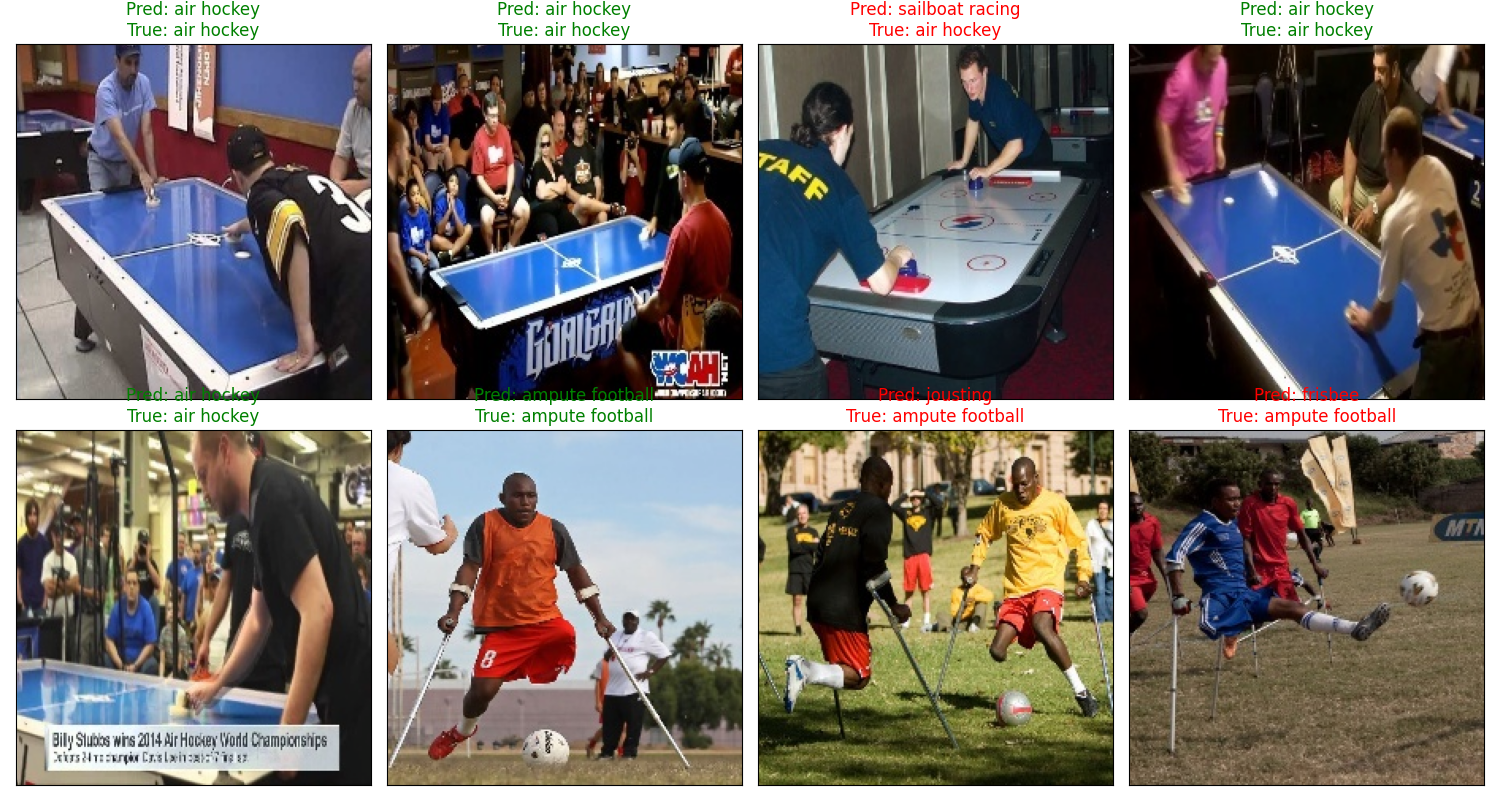

# 4. Describe your experience on fine-tuning and show the graphs. ✅

The fine tuning was done as follows::

## Performance Patterns

**Perfect Classification (100% Accuracy)**
The model achieved perfect accuracy in several sports that have distinctive visual characteristics:
- Balance beam
- Boxing
- Curling
- Giant slalom
- Ice climbing
- Ice yachting
- Jai alai
- Polo
- Swimming
- Water polo

**Zero Performance (0% Accuracy)**
Interestingly, the model completely failed to classify certain sports:
- Frisbee
- Gaga
- Parallel bar
- Trapeze
- Ultimate

## Training Insights

**Learning Progression**
- The model showed rapid initial improvement, jumping from 6.51% accuracy in epoch 1 to 42% by epoch 14
- The learning rate decreased from 0.0001 to 9.87e-8 over 50 epochs, showing fine-tuning of weights

**Performance Plateaus**
- The model hit several performance plateaus, particularly between epochs 35-50
- The best validation accuracy (55.00%) was achieved in epoch 42

## Interesting Correlations

**Sport Type Patterns**
- Individual sports generally had better classification accuracy than team sports
- Indoor sports with fixed environments (like swimming, boxing) showed higher accuracy than outdoor sports with variable conditions

**Visual Distinctiveness**
- Sports with unique equipment or settings (like ice yachting, curling) were classified more accurately
- Sports with similar visual elements (like different types of racing) showed more classification confusion

----------------

Here is the training history for the first 50 epochs:

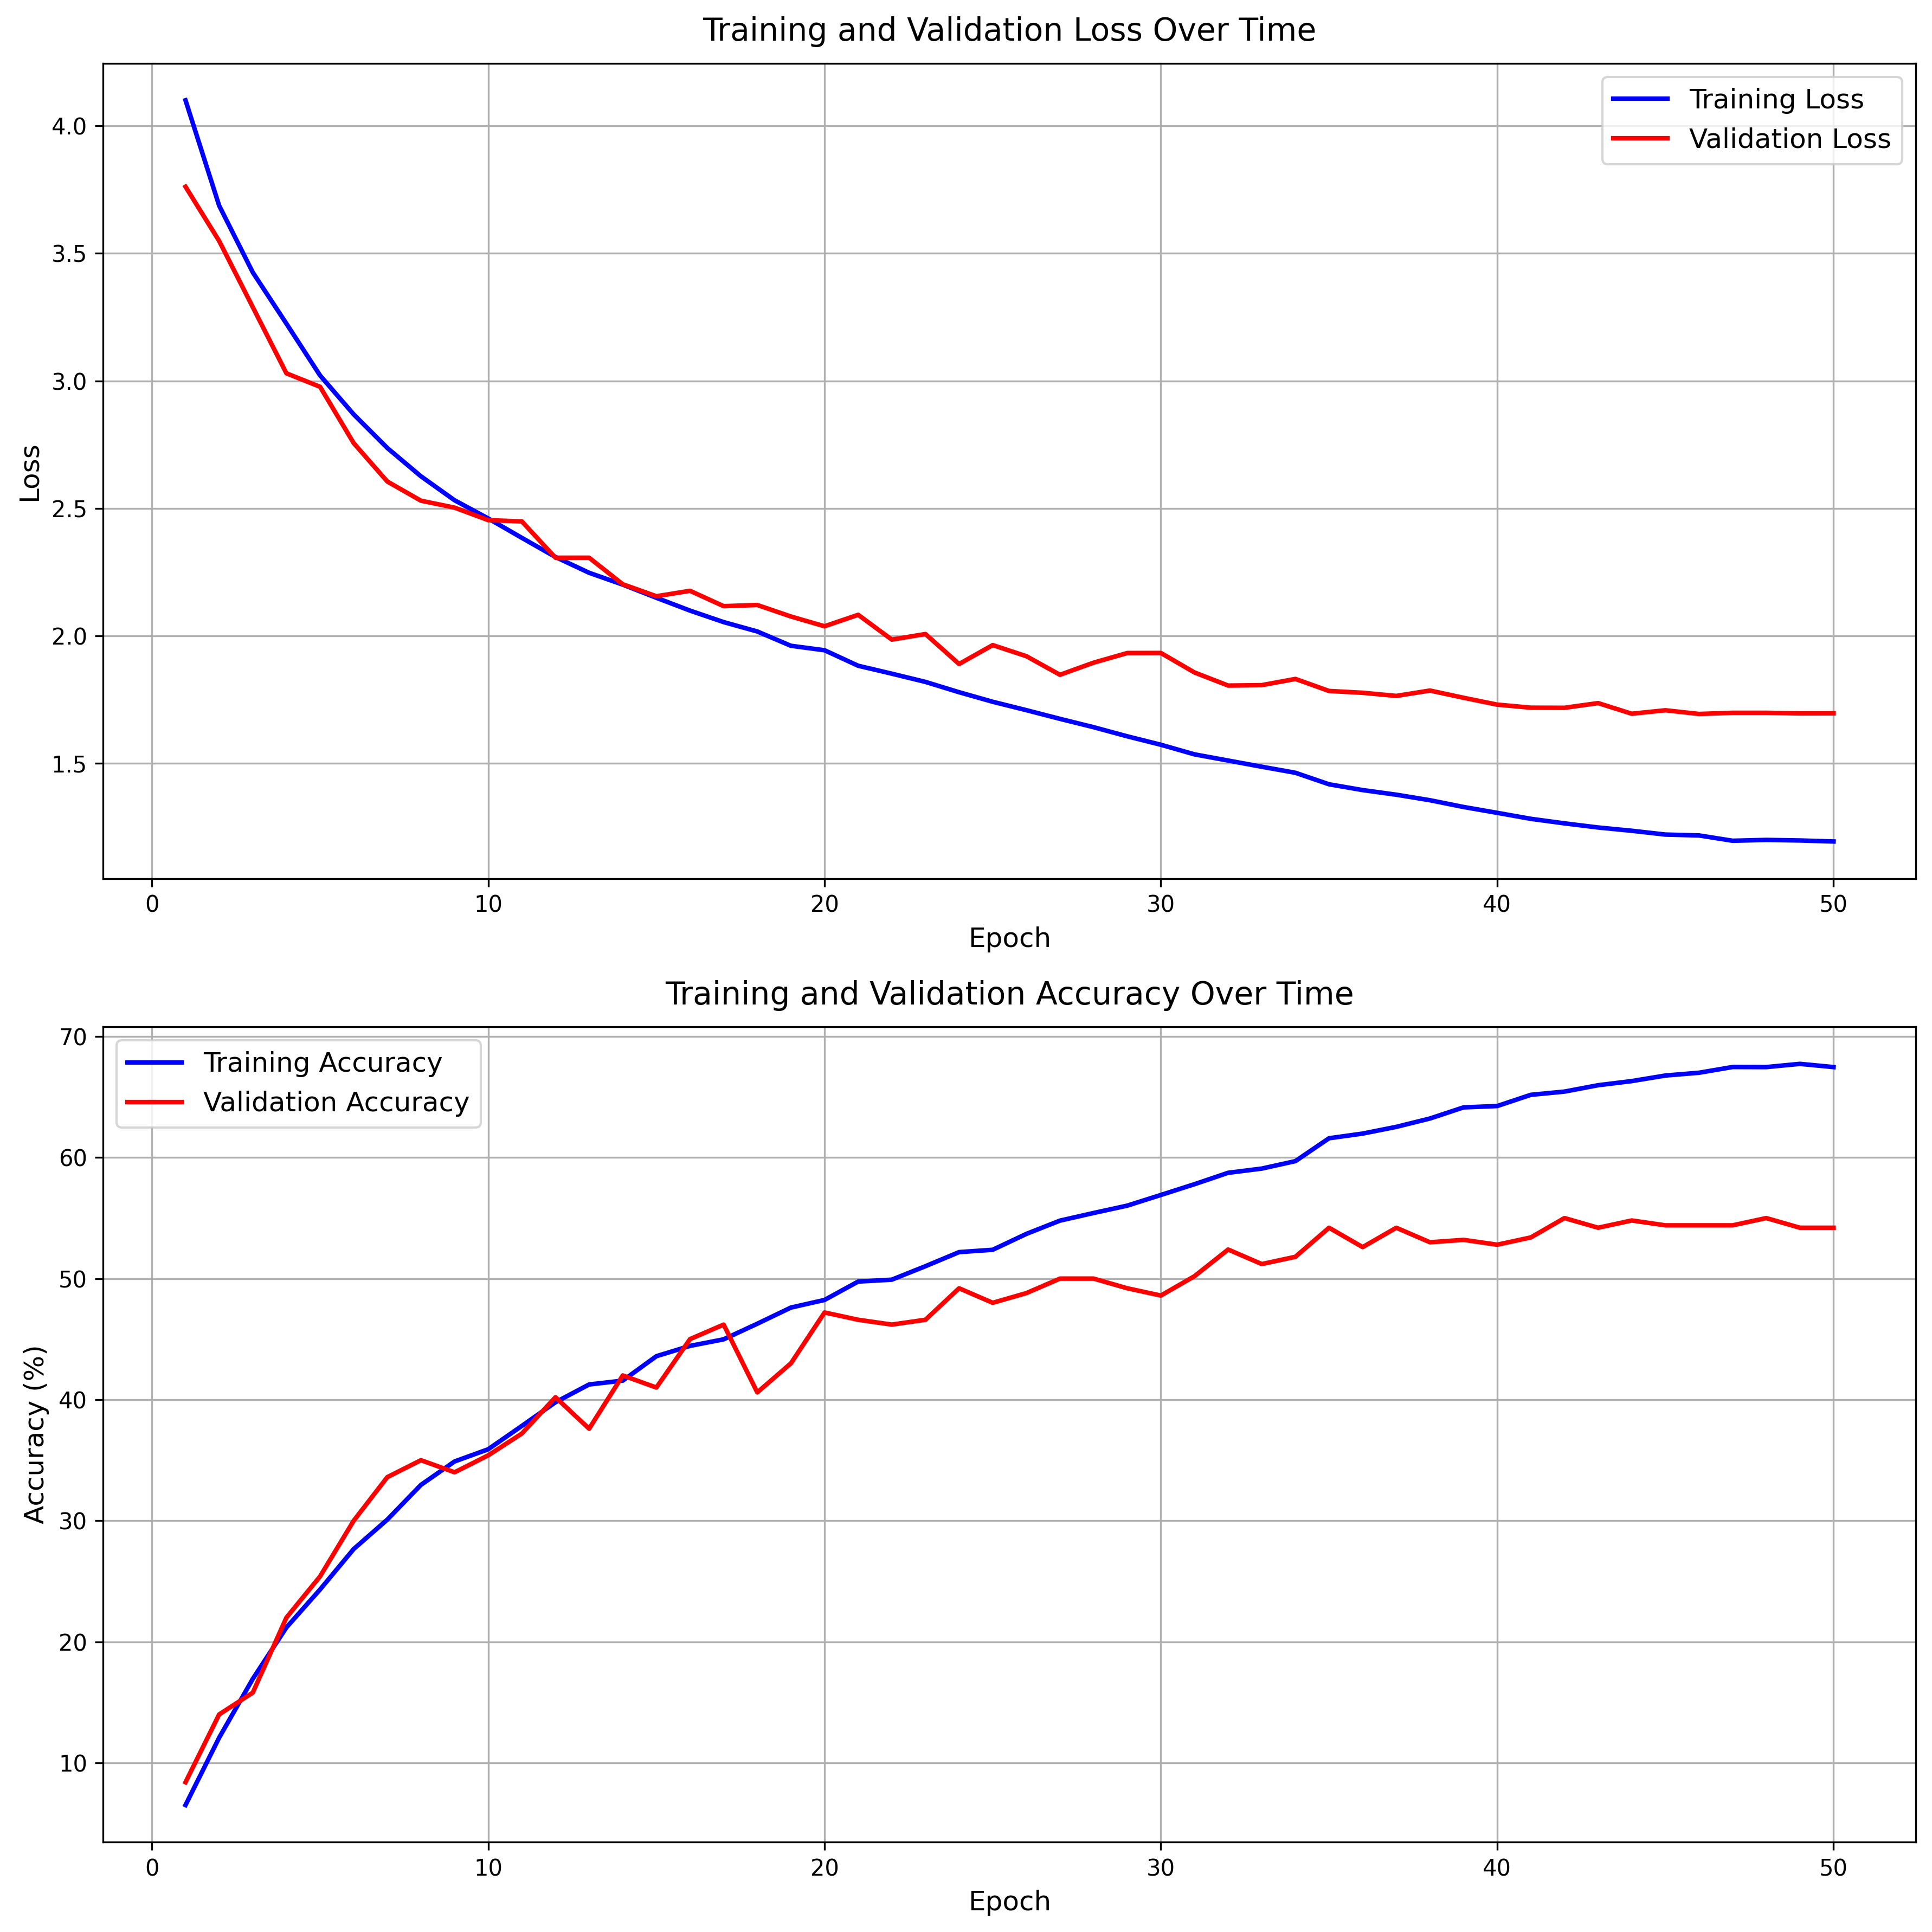

The final test report after training for an additional 50 epochs was as follows:

```
Test Set Evaluation Report
==================================================
Overall Accuracy: 61.60%

Per-Class Performance:
--------------------------------------------------
Class                          Accuracy   Samples   
--------------------------------------------------
air hockey                        60.00%          5
ampute football                   60.00%          5
archery                           20.00%          5
arm wrestling                     60.00%          5
axe throwing                      60.00%          5
balance beam                     100.00%          5
barell racing                     80.00%          5
baseball                          60.00%          5
basketball                        60.00%          5
baton twirling                    20.00%          5
bike polo                         60.00%          5
billiards                        100.00%          5
bmx                                0.00%          5
bobsled                           40.00%          5
bowling                           60.00%          5
boxing                            80.00%          5
bull riding                       80.00%          5
bungee jumping                    60.00%          5
canoe slamon                     100.00%          5
cheerleading                      40.00%          5
chuckwagon racing                100.00%          5
cricket                           60.00%          5
croquet                           60.00%          5
curling                          100.00%          5
disc golf                         40.00%          5
fencing                           40.00%          5
field hockey                      80.00%          5
figure skating men                20.00%          5
figure skating pairs              80.00%          5
figure skating women              80.00%          5
fly fishing                       80.00%          5
football                          80.00%          5
formula 1 racing                  80.00%          5
frisbee                           20.00%          5
gaga                              20.00%          5
giant slalom                     100.00%          5
golf                              40.00%          5
hammer throw                      80.00%          5
hang gliding                     100.00%          5
harness racing                    40.00%          5
high jump                        100.00%          5
hockey                            60.00%          5
horse jumping                     60.00%          5
horse racing                      60.00%          5
horseshoe pitching                20.00%          5
hurdles                           80.00%          5
hydroplane racing                 40.00%          5
ice climbing                     100.00%          5
ice yachting                     100.00%          5
jai alai                         100.00%          5
javelin                           80.00%          5
jousting                          60.00%          5
judo                              80.00%          5
lacrosse                          20.00%          5
log rolling                       60.00%          5
luge                              60.00%          5
motorcycle racing                 80.00%          5
mushing                           80.00%          5
nascar racing                     40.00%          5
olympic wrestling                100.00%          5
parallel bar                      40.00%          5
pole climbing                     80.00%          5
pole dancing                      60.00%          5
pole vault                        60.00%          5
polo                             100.00%          5
pommel horse                     100.00%          5
rings                              0.00%          5
rock climbing                     80.00%          5
roller derby                      60.00%          5
rollerblade racing                60.00%          5
rowing                            60.00%          5
rugby                             80.00%          5
sailboat racing                  100.00%          5
shot put                          40.00%          5
shuffleboard                      60.00%          5
sidecar racing                    40.00%          5
ski jumping                        0.00%          5
sky surfing                       60.00%          5
skydiving                         80.00%          5
snow boarding                      0.00%          5
snowmobile racing                 60.00%          5
speed skating                     80.00%          5
steer wrestling                   40.00%          5
sumo wrestling                    60.00%          5
surfing                           60.00%          5
swimming                         100.00%          5
table tennis                      60.00%          5
tennis                            20.00%          5
track bicycle                    100.00%          5
trapeze                            0.00%          5
tug of war                        20.00%          5
ultimate                          20.00%          5
uneven bars                       60.00%          5
volleyball                        60.00%          5
water cycling                     60.00%          5
water polo                       100.00%          5
weightlifting                     60.00%          5
wheelchair basketball             40.00%          5
wheelchair racing                 40.00%          5
wingsuit flying                   80.00%          5
```

The final training history is as follows:

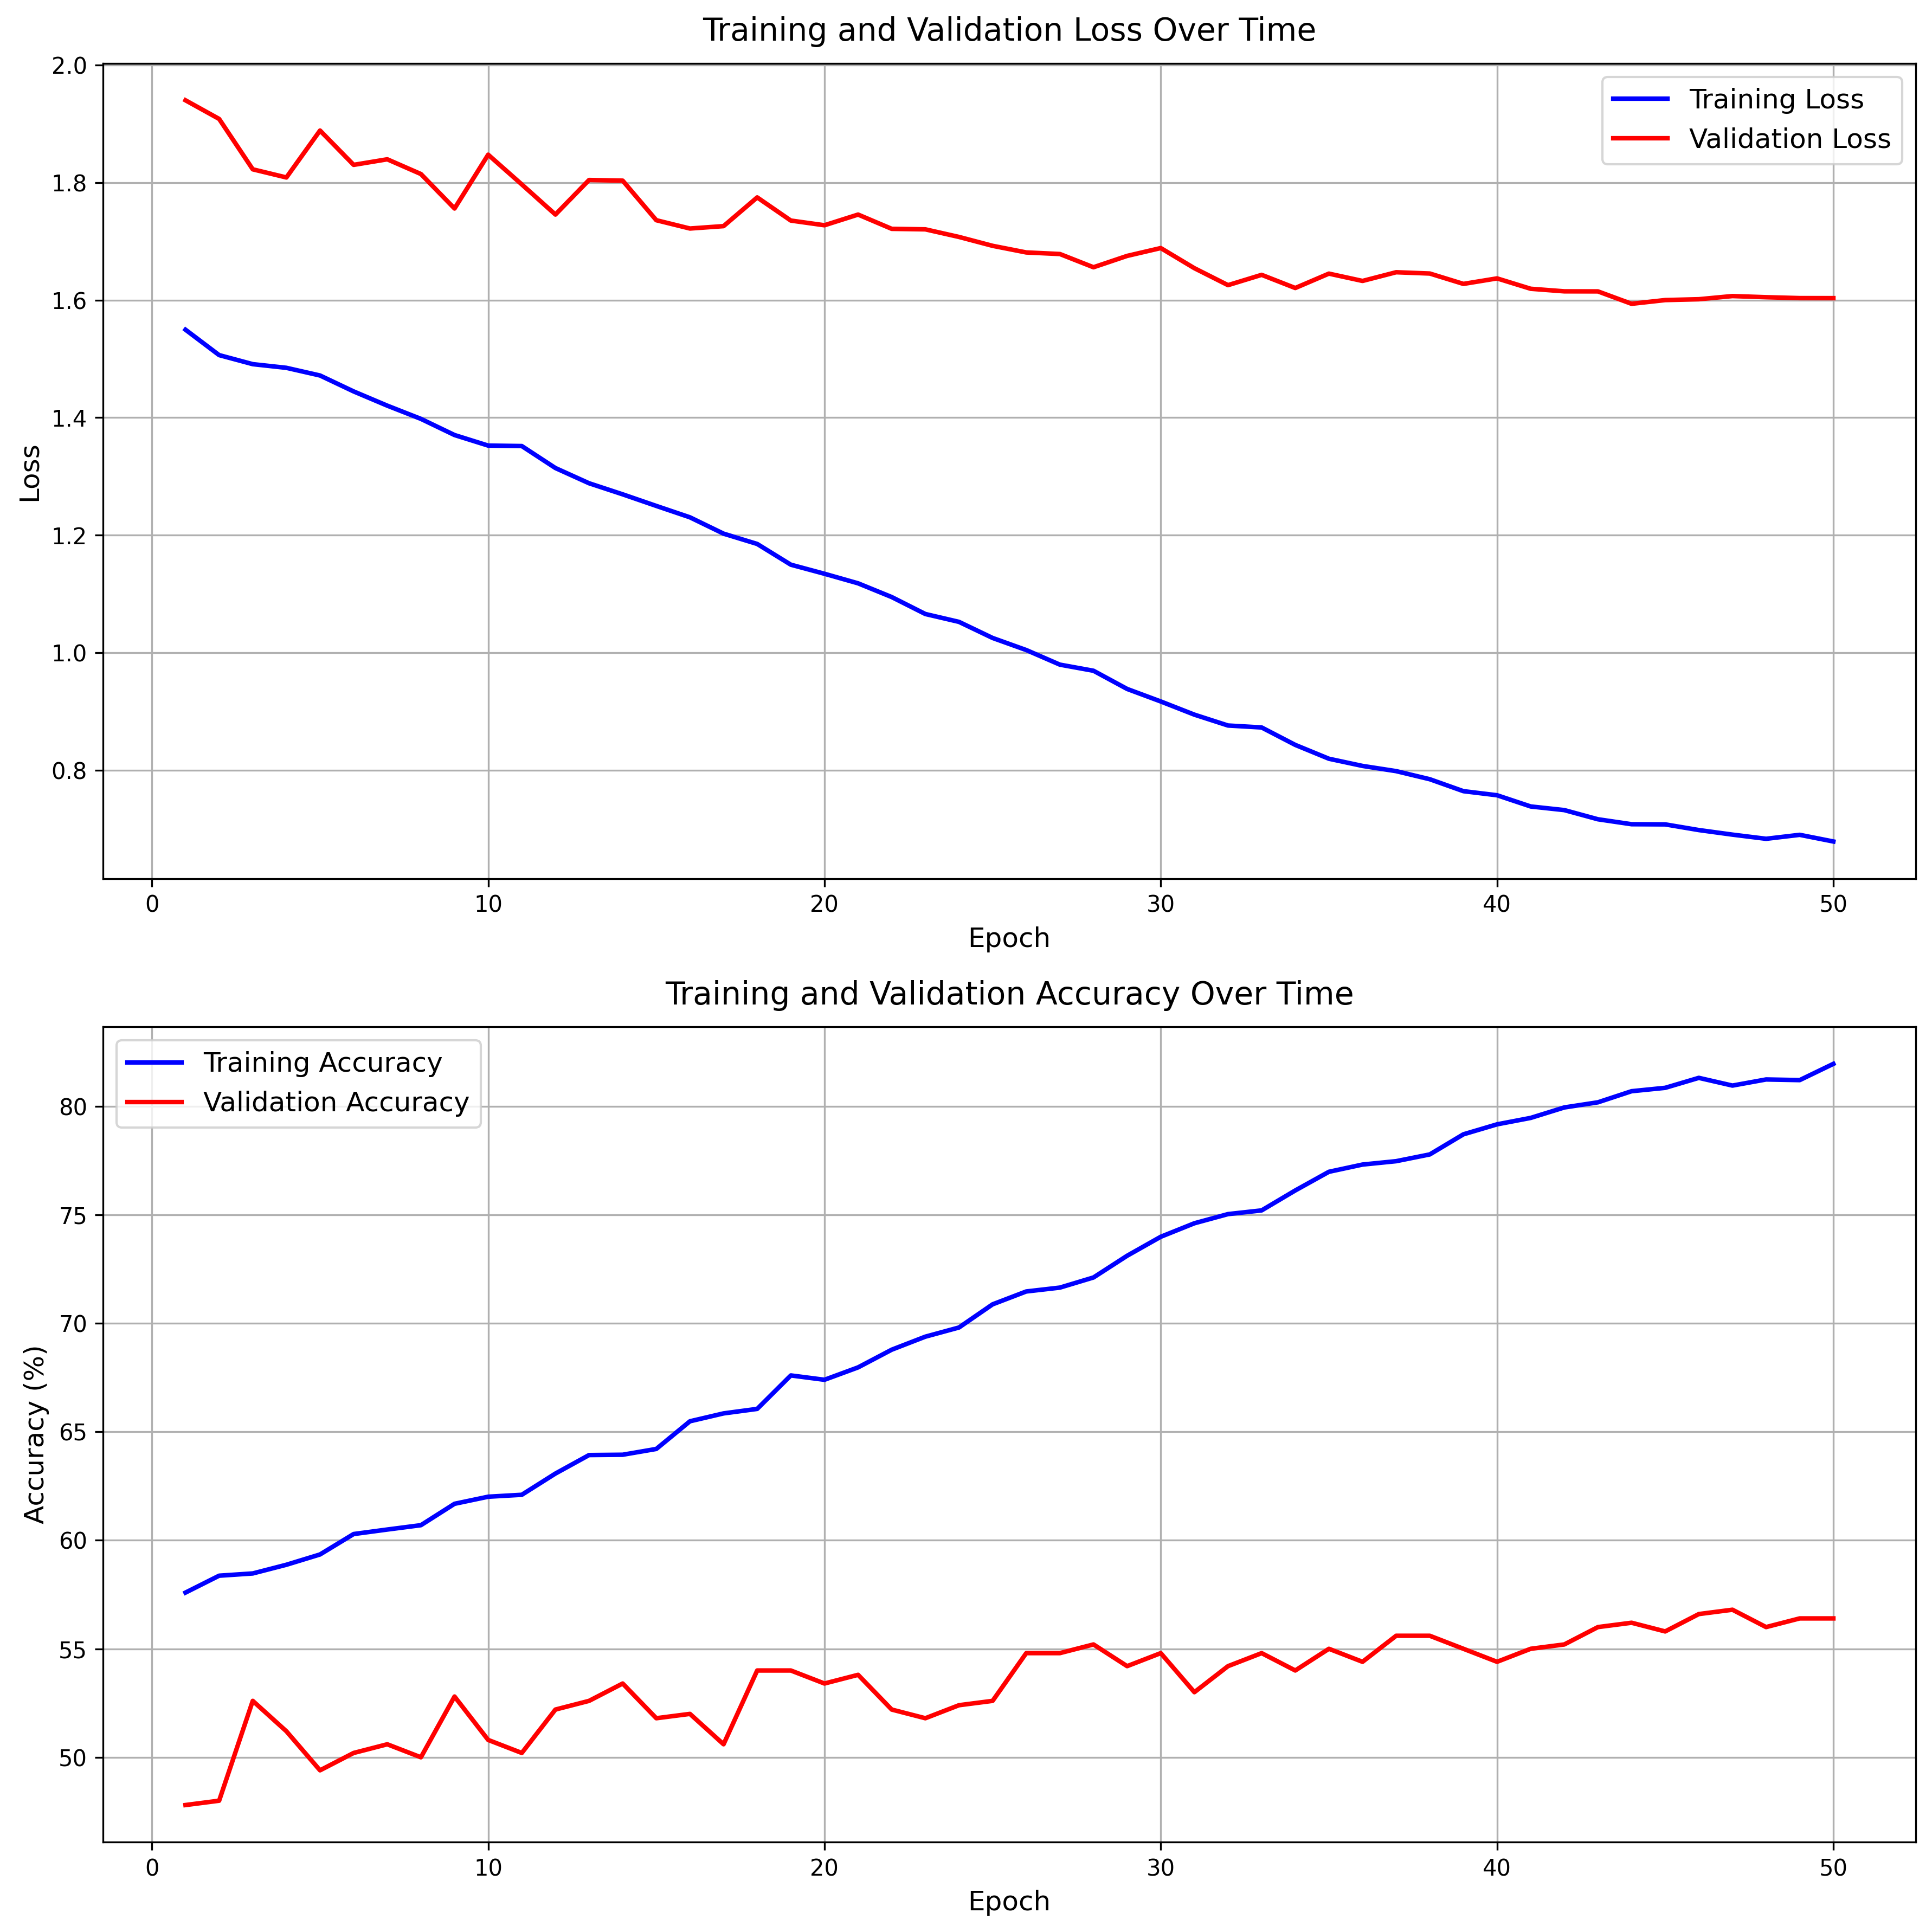

And the final test predictions are as follows:

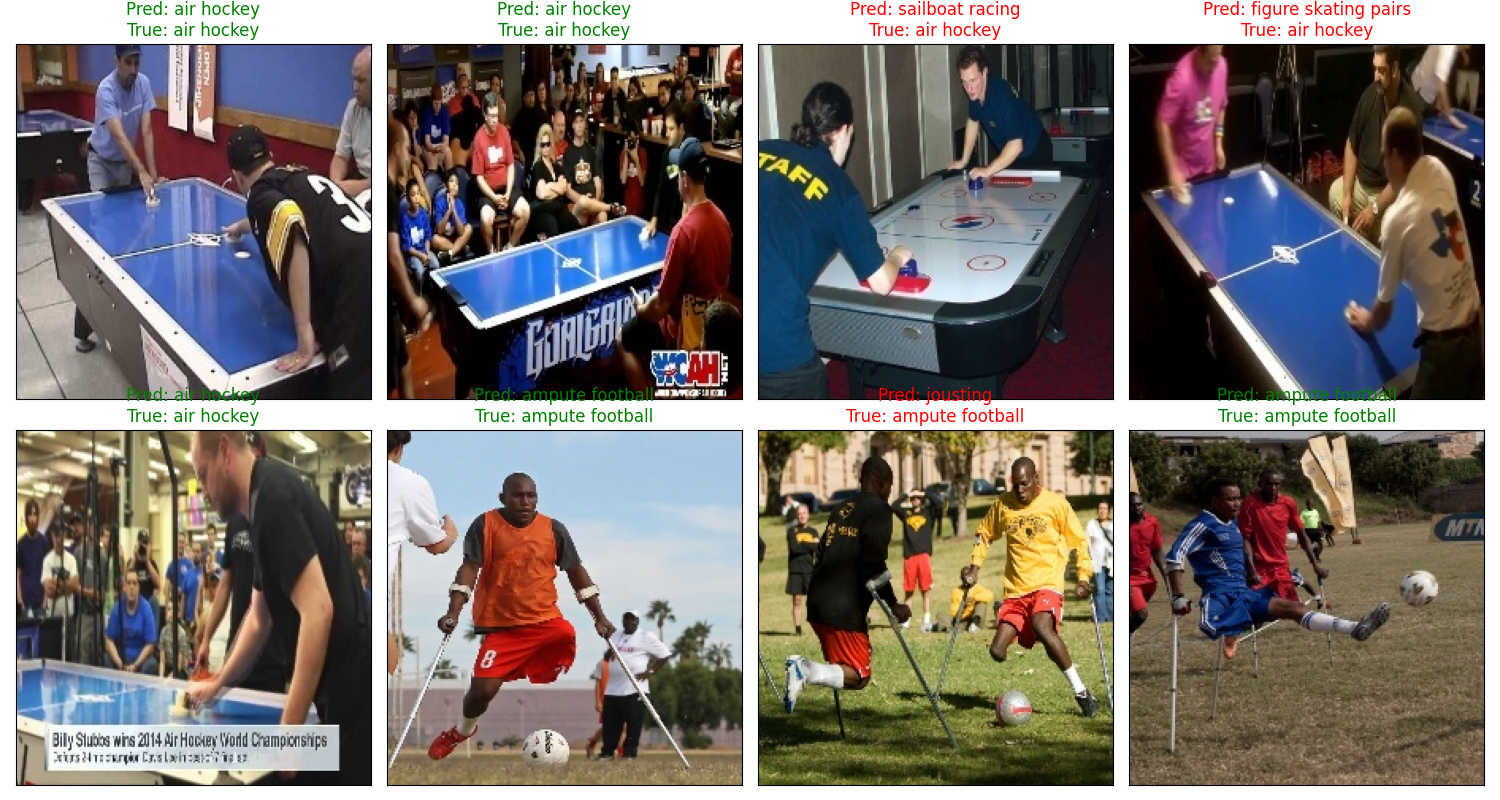


# Thank You 🤗
 
Here's the Github Repository Link: https://github.com/aryashah2k/RTML/tree/main/A3

Model Checkpoints and Weights can be downloaded from the Terabox Drive here: https://1024terabox.com/s/1FY-YmkfRRXlc74u7GQtTNg